In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 5264818, TESS data only

- also known as TIC 121732964 

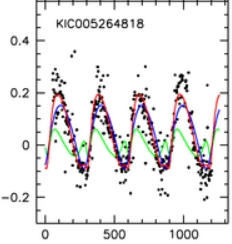

(x, time-span: ~1300 d ; y, O-C in kilosecs)

Source:  `2013ApJ...768...33R` [Triple-star Candidates among the Kepler Binaries](https://ui.adsabs.harvard.edu/abs/2013ApJ...768...33R/abstract) 


In [5]:
# define the plotting parameters

figsize = (8,4)

In [3]:
# import the data

# choose a TIC ID to analyze
ticid = 121732964
kicid = 5264818  # ETV amplitude ~300s
# reference: 2013ApJ
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary_tess.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary_tess.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u



# sr = lk.search_lightcurve('KIC{}'.format(kicid))
# sr = sr[sr.exptime == 1800 * u.s]  # exclude 1 quarter that has both 30min and 1min cadence data
# sr = lke._sort_chronologically(sr)
# display(sr)
# lcc_kplr = sr.download_all()
# lc_kplr = lcc_kplr[:].stitch()
# lc_kplr.time.format = "mjd"  # to be consistent with the paper result, also for ease of combining with TESS data
# lc_kplr = lc_kplr.truncate(None, 55800)  # test with ~2 ETV cycles based on reference plot

sr = lk.search_lightcurve('TIC {}'.format(ticid), author="SPOC")  # all available TESS sectors has short cadence data
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
lc_tess.time.format = "mjd"

search_result = lk.LightCurveCollection([
    # lc_kplr,
    lc_tess,
]).stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 14 2019   SPOC     120   121732964      0.0     G022062
  1 TESS Sector 40 2021   SPOC     120   121732964      0.0      G04171
  2 TESS Sector 41 2021   SPOC     120   121732964      0.0      G04171
  3 TESS Sector 54 2022   SPOC     120   121732964      0.0      G04171
  4 TESS Sector 55 2022   SPOC     120   121732964      0.0      G04171

93138

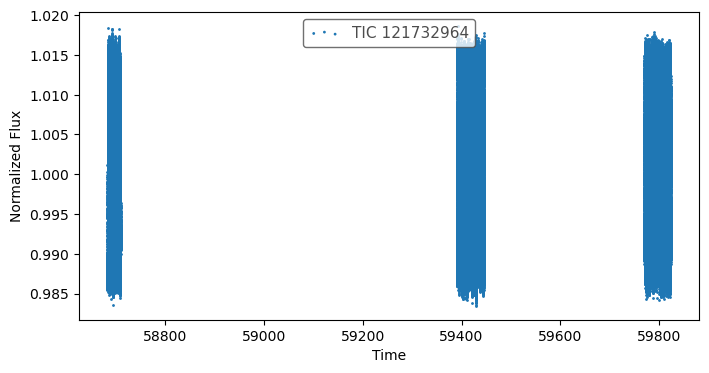

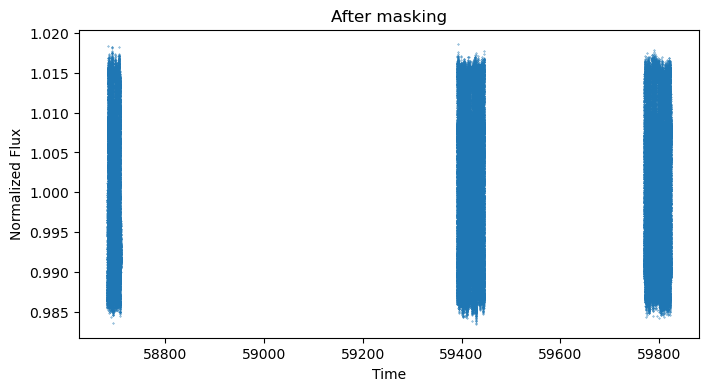

In [6]:
%matplotlib inline
%matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

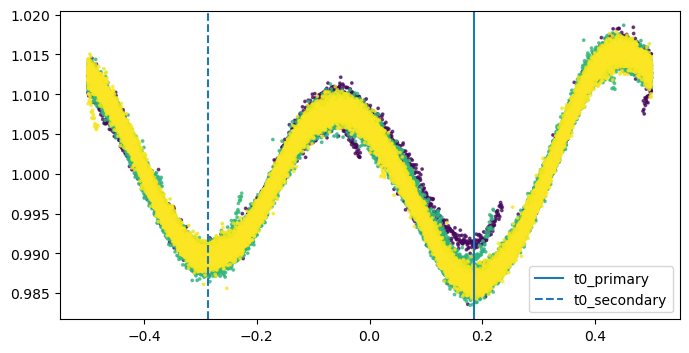

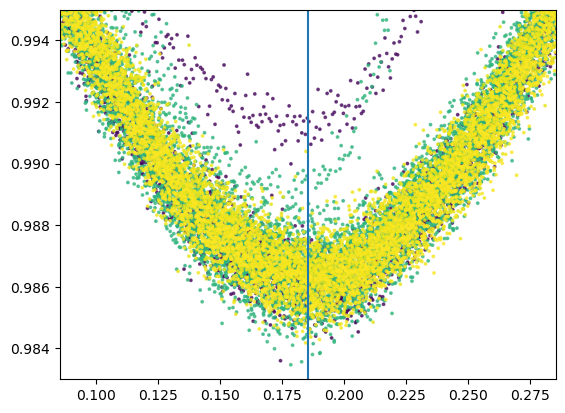

In [11]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# period = 1.9050502  # Kepler EB Period
period = 1.905052  # 2013ApJ Period


# add a 0.02 day offset to make it line up better with TESS data
t0_primary = 54955.233438 - 0.5 + 0.02 # Kepler EB, the MJD there seems to be off by 0.5
t0_secondary = t0_primary + period * 0.5290


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 0.2229 * period * 24  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = 0.2353 * period * 24  

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.35  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.10, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.10);
plt.ylim(0.983, 0.995);
plt.show()

### Now that the data is ready we can start 

In [12]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0      58682.856653  0.989592  0.000629  0.141293
1      58682.858042  0.989638  0.000629  0.142023
2      58682.859431  0.989926  0.000630  0.142752
3      58682.860820  0.988759  0.000630  0.143481
4      58682.862209  0.990117  0.000630  0.144210
...             ...       ...       ...       ...
93132  59823.759721  1.000218  0.000531  0.024194
93133  59823.761110  1.000160  0.000531  0.024923
93134  59823.762499  0.999718  0.000531  0.025652
93135  59823.763887  0.999513  0.000531  0.026381
93136  59823.765276  0.999866  0.000531  0.027110

[93137 rows x 4 columns]

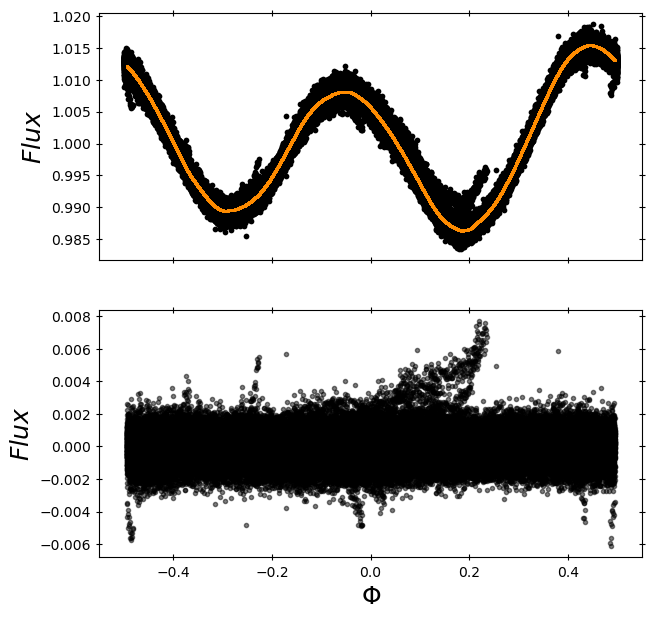

time      flux       err     phase  flux_sub_binary  \
0      58682.856653  0.989592  0.000629  0.141293         0.001018   
1      58682.858042  0.989638  0.000629  0.142023         0.001128   
2      58682.859431  0.989926  0.000630  0.142752         0.001479   
3      58682.860820  0.988759  0.000630  0.143481         0.000374   
4      58682.862209  0.990117  0.000630  0.144210         0.001792   
...             ...       ...       ...       ...              ...   
93132  59823.759721  1.000218  0.000531  0.024194        -0.003075   
93133  59823.761110  1.000160  0.000531  0.024923        -0.003056   
93134  59823.762499  0.999718  0.000531  0.025652        -0.003422   
93135  59823.763887  0.999513  0.000531  0.026381        -0.003550   
93136  59823.765276  0.999866  0.000531  0.027110        -0.003121   

       binary_model  
0          0.988574  
1          0.988510  
2          0.988447  
3          0.988385  
4          0.988325  
...             ...  
93132      1.003293  
93133      1.003216  
93134      1.003140  
93135      1.003063  
93136      1.002987  

[93137 rows x 6 columns]

In [13]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 92204 901
reached the end
10 91354 901
reached the end
10 91112 901
reached the end
10 90937 901
reached the end
10 90890 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      58682.856653  0.989592  0.000629  0.141293         0.001018   
1      58682.858042  0.989638  0.000629  0.142023         0.001128   
2      58682.859431  0.989926  0.000630  0.142752         0.001479   
3      58682.860820  0.988759  0.000630  0.143481         0.000374   
4      58682.862209  0.990117  0.000630  0.144210         0.001792   
...             ...       ...       ...       ...              ...   
93132  59823.759721  1.000218  0.000531  0.024194        -0.003075   
93133  59823.761110  1.000160  0.000531  0.024923        -0.003056   
93134  59823.762499  0.999718  0.000531  0.025652        -0.003422   
93135  59823.763887  0.999513  0.000531  0.026381        -0.003550   
93136  59823.765276  0.999866  0.000531  0.027110        -0.003121   

       binary_model  flux_detrended  
0          0.988574        0.988521  
1          0.988510        0.988572  
2          0.988447        0.988865  
3          0.988385        0.987704  
4          0.988325        0.989066  
...             ...             ...  
93132      1.003293        1.003068  
93133      1.003216        1.003069  
93134      1.003140        1.002687  
93135      1.003063        1.002533  
93136      1.002987        1.002936  

[93137 rows x 7 columns]

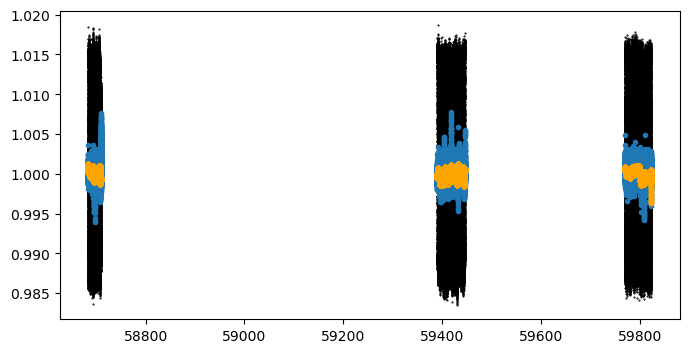

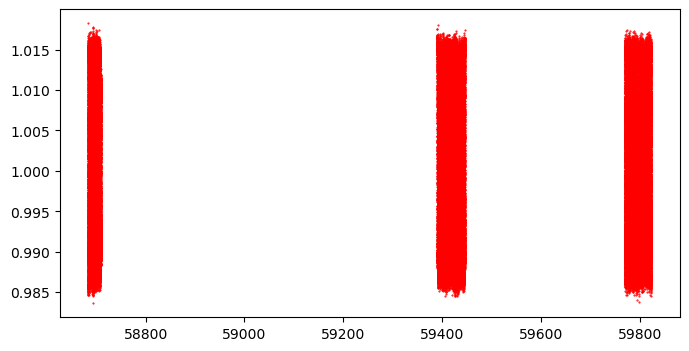

In [14]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

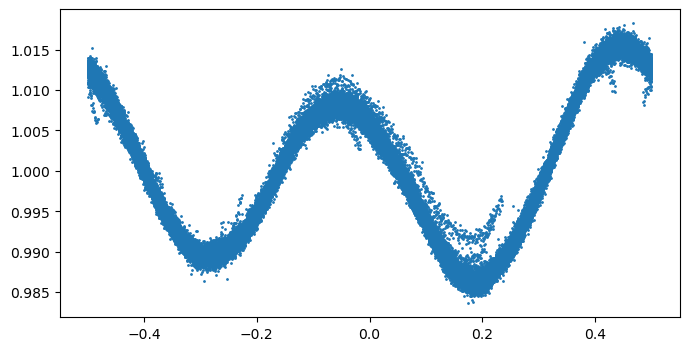

In [15]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   58681.035149999996 0.18514999999969273
window_width_p (phase): 0.144885
Secondary: 58682.042922508 -0.2858499999979116
window_width_s (phase): 0.152945


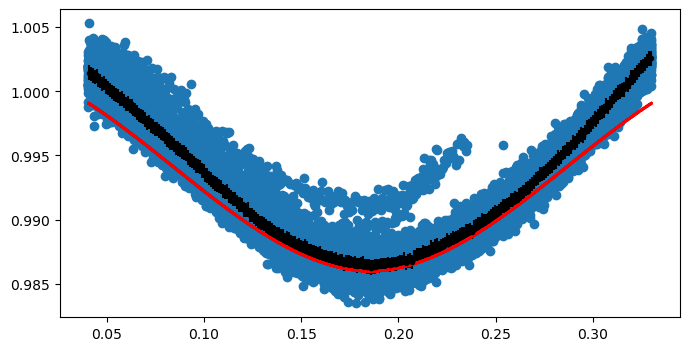

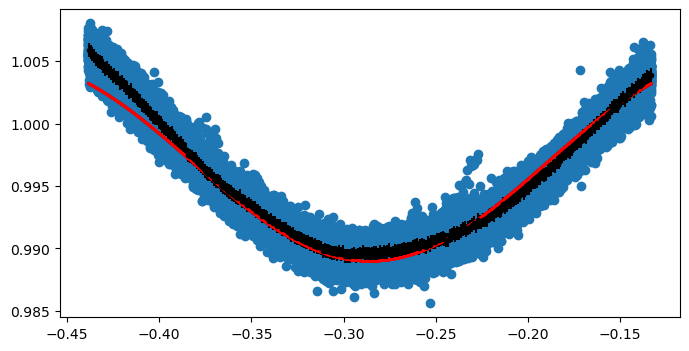

In [41]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.65 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    window_width_s = 0.65 * duration_hr_secondary / 24 / period
    # window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.004, -0.018, midpoint_p, 0.1, 0.93]
start_vals_s = [1.006, -0.017, midpoint_s, 0.09, 1.0]


# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

100%|██████████████████████████████████████████████████████████| 1000/1000 [05:35<00:00,  2.98it/s]


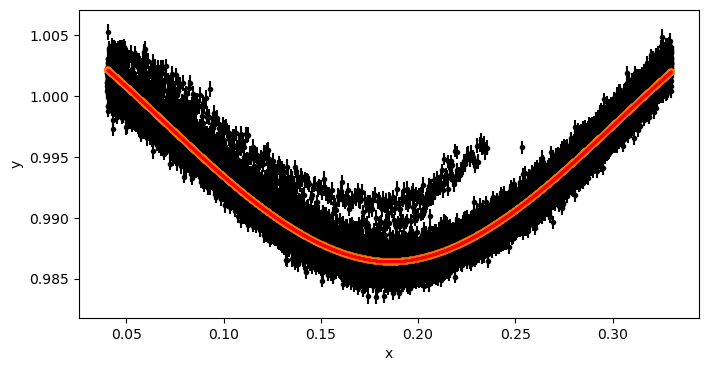

100%|██████████████████████████████████████████████████████████| 1000/1000 [05:50<00:00,  2.85it/s]


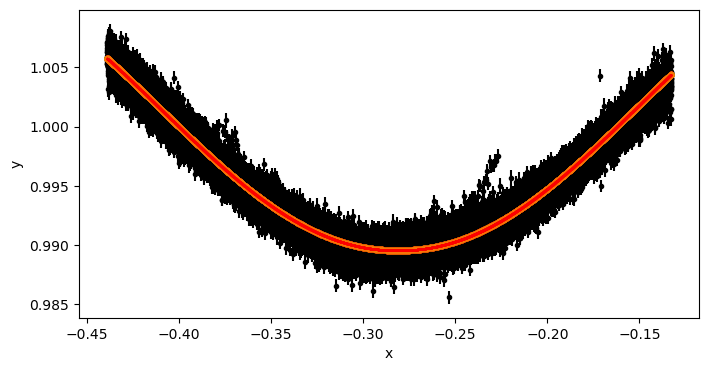

In [46]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")

    # # initial fit params from Kepler data (<MJD 55800) 2013Apj Period
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0079770953810983, -0.021266856349716978, 0.1679917286817513, 0.10103761588580798, 0.9377701388816556
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.017958545579376, -0.02877616684866633, -0.30112563808942394, 0.13300990936997456, 0.9516544755371867

    # initial fit params from TESS data, 2013Apj Period
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0117904588740738, -0.025374150600713987, 0.18570110443988325, 0.1141043985832406, 0.9449417805276087
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0152185422063402, -0.025665158615984437, -0.2811307789926589, 0.11802993738170114, 1.0476145753802337

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [47]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0117904588740738, -0.025374150600713987, 0.18570110443988325, 0.1141043985832406, 0.9449417805276087
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0152185422063402, -0.025665158615984437, -0.2811307789926589, 0.11802993738170114, 1.0476145753802337


598

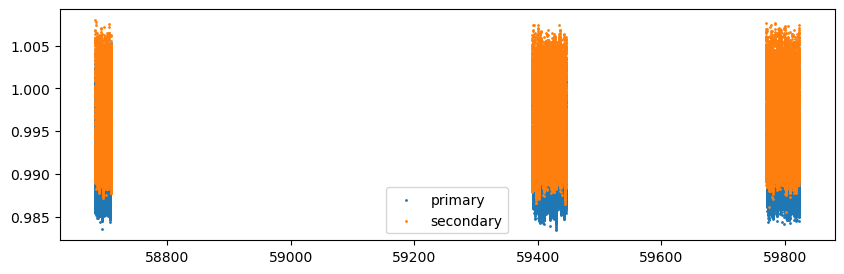

In [60]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

58681.035149999996 1.905052 58681.035149999996


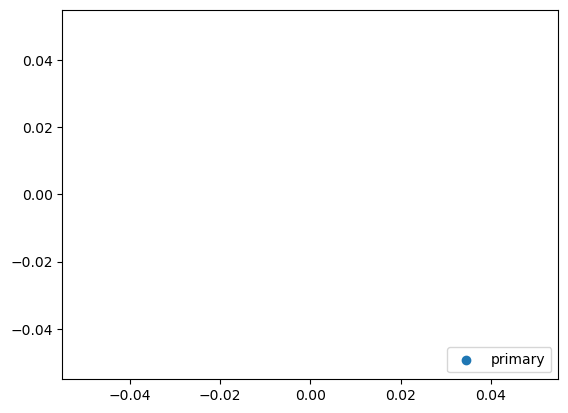

58681.035149999996 1.905052 58682.940202


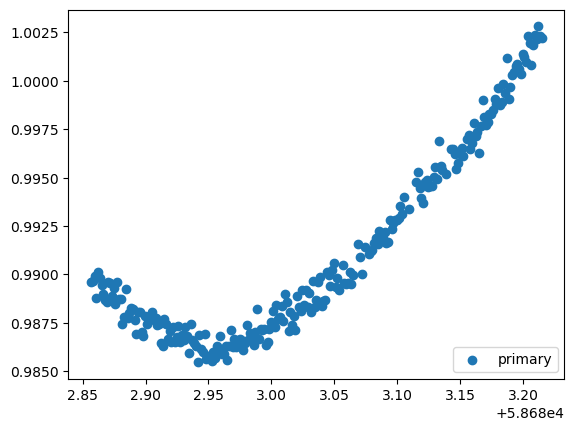

58681.035149999996 1.905052 58684.84525399999


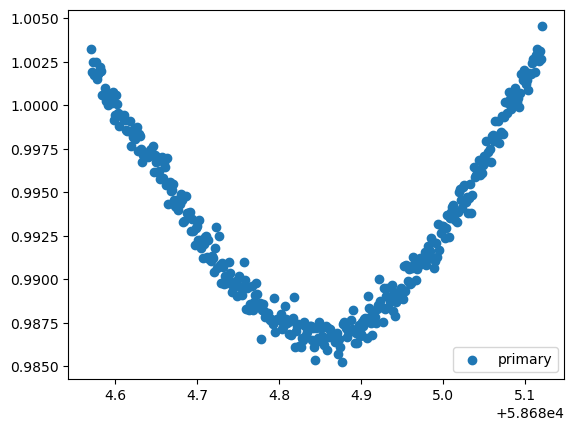

58682.042922508 1.905052 58682.042922508


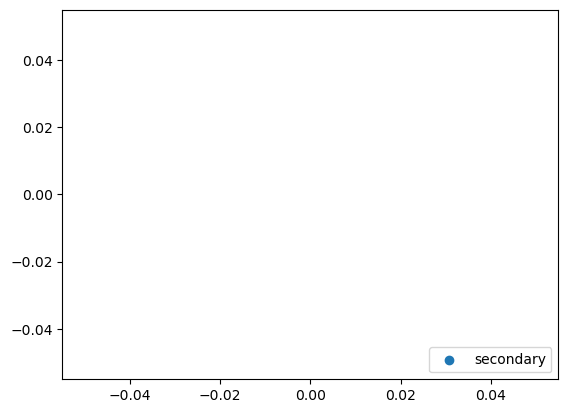

58682.042922508 1.905052 58683.947974508


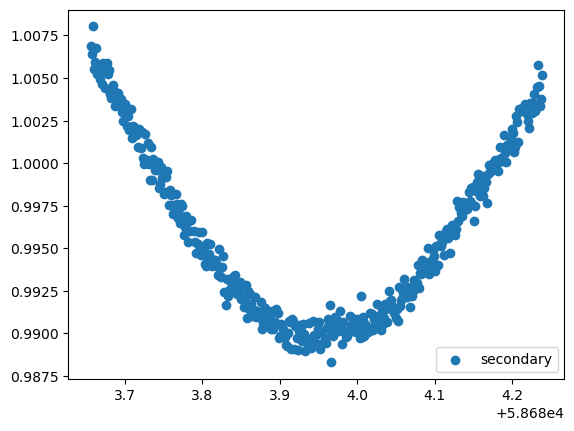

58682.042922508 1.905052 58685.853026508


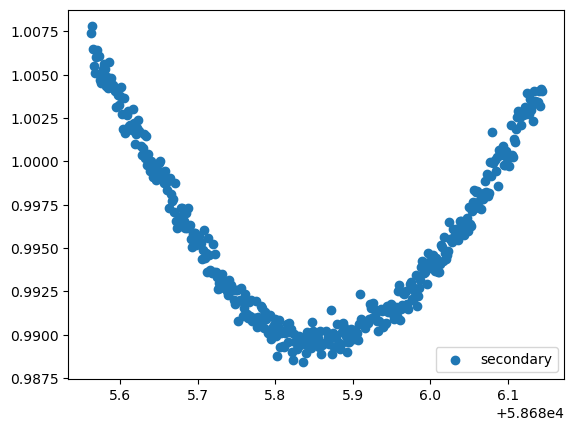

In [61]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Creating new manifest file
58682.940202 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.47it/s]


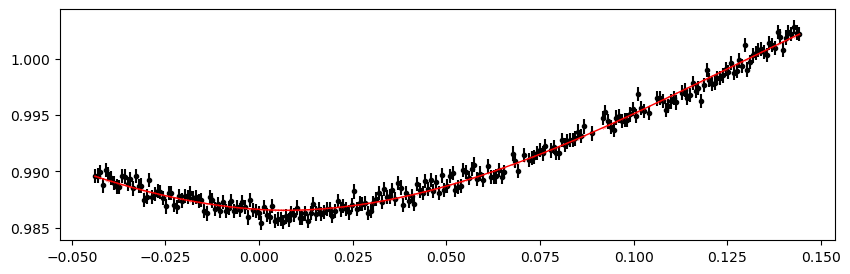

58684.84525399999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.27it/s]


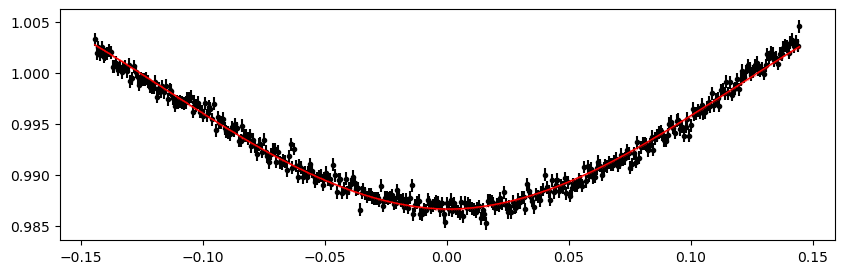

58686.750305999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.48it/s]


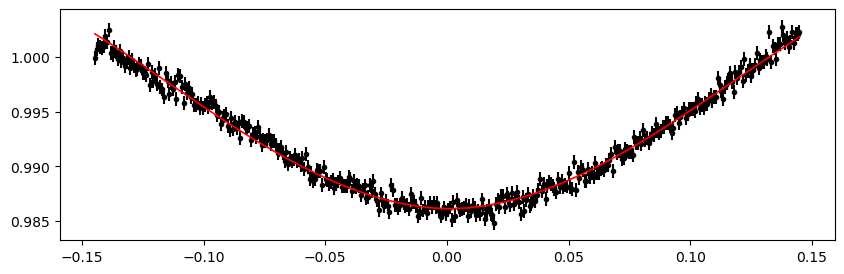

58688.655357999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.32it/s]


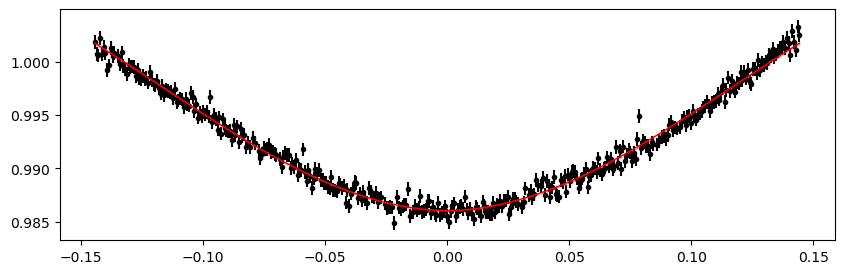

58690.56041 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.41it/s]


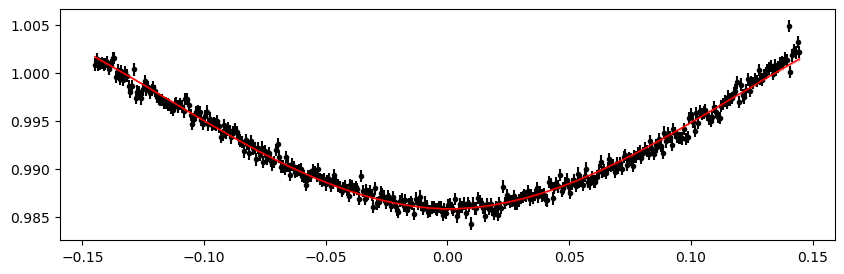

58692.46546199999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.27it/s]


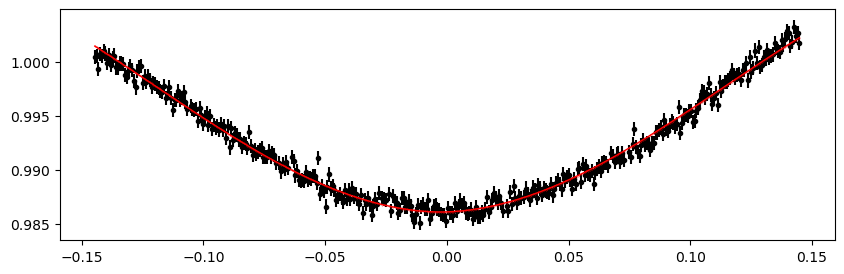

58694.370513999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.08it/s]


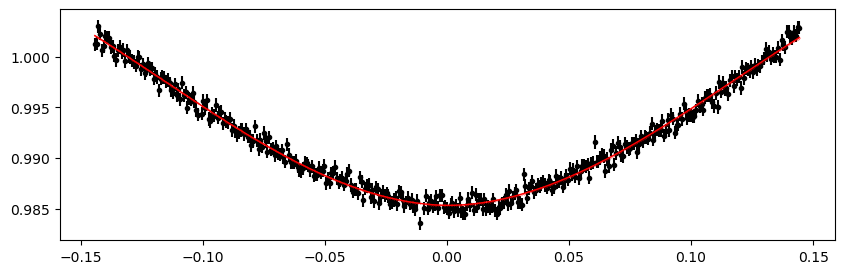

58698.180618 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.37it/s]


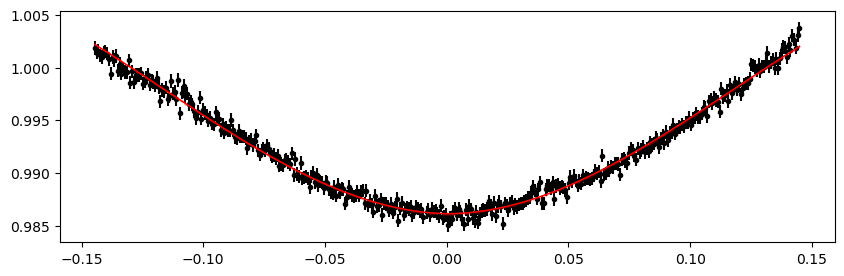

58700.08566999999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 263.08it/s]


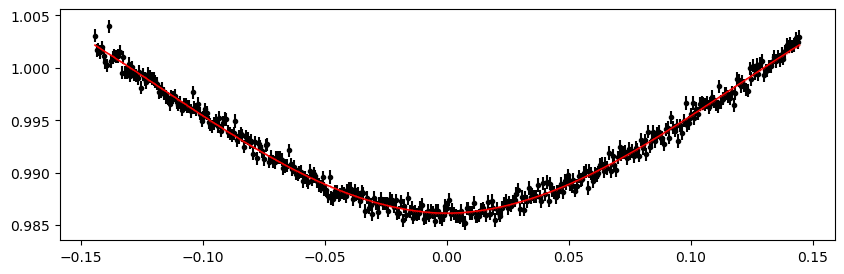

58701.990721999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.07it/s]


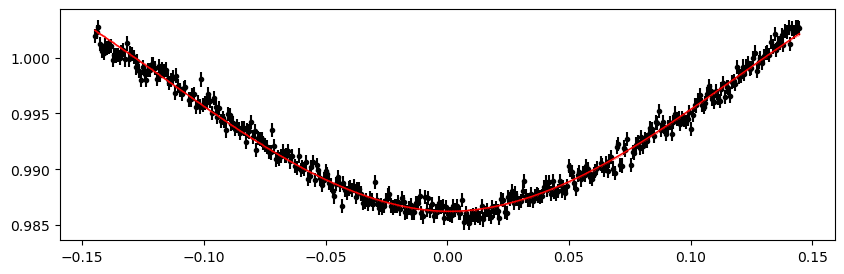

58703.895774 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.95it/s]


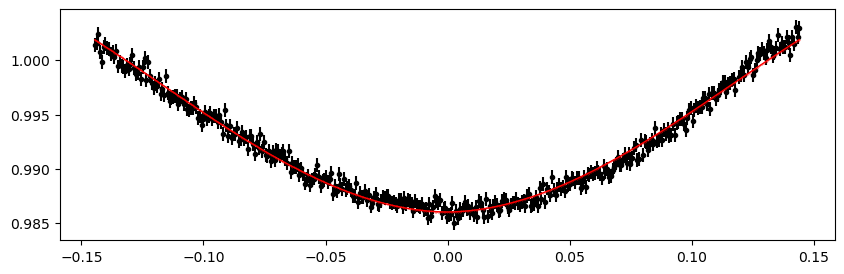

58705.800826 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.15it/s]


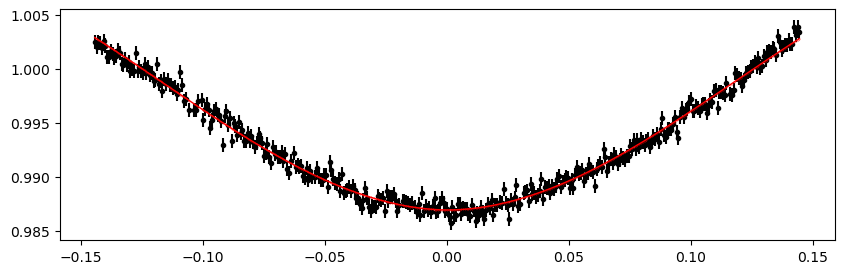

58707.70587799999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.29it/s]


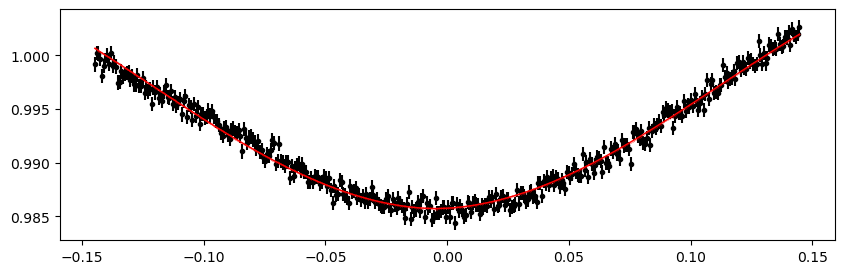

58709.610929999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 282.26it/s]


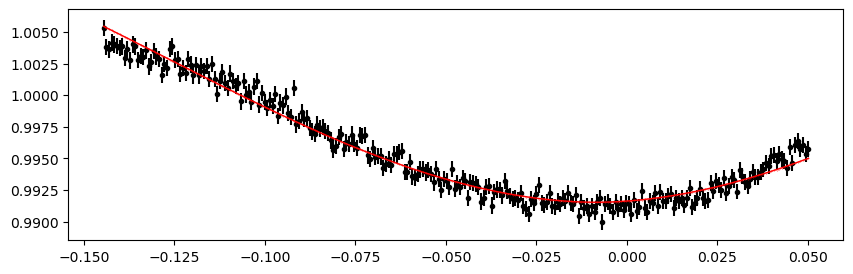

59391.619545999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.80it/s]


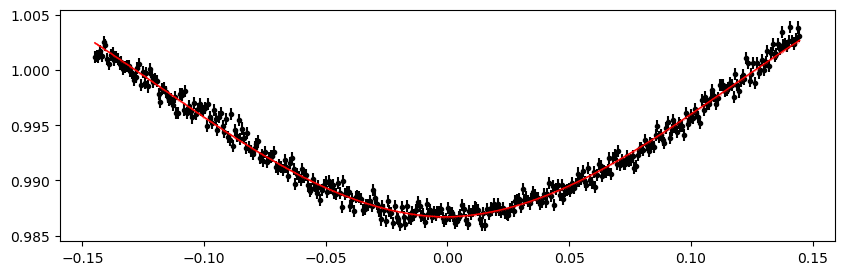

59393.524597999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.82it/s]


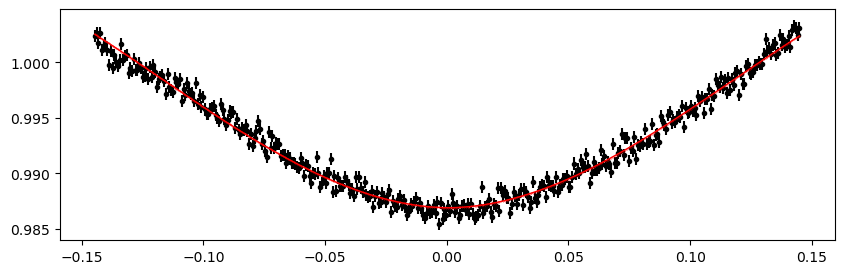

59395.42965 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 233.82it/s]


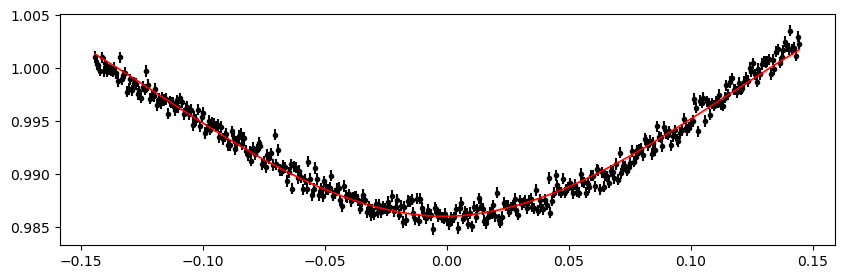

59397.33470199999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.88it/s]


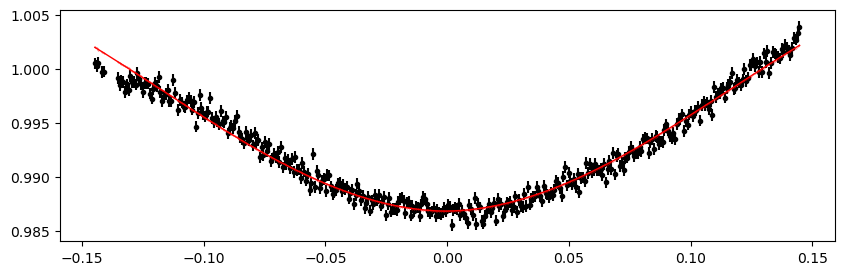

59399.239753999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.43it/s]


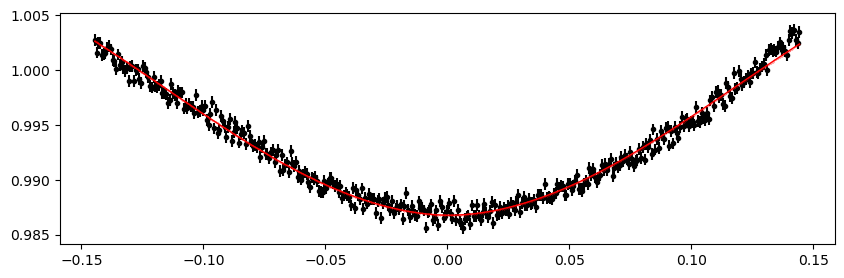

59401.144806 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 232.26it/s]


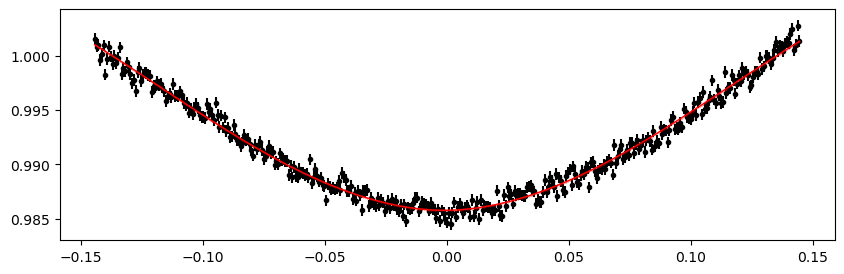

59403.049858 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.36it/s]


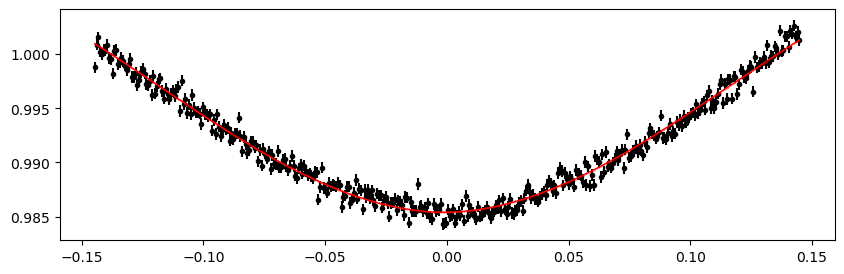

59404.95490999999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.02it/s]


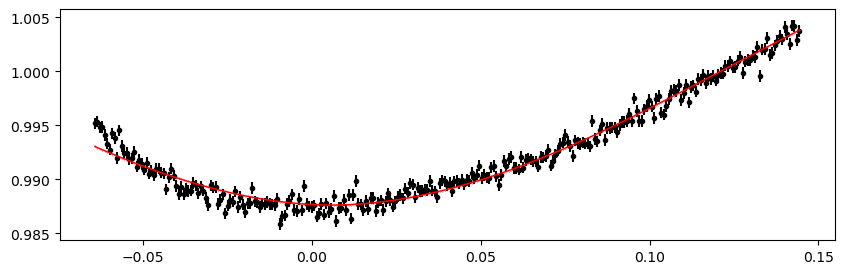

59406.859961999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 268.10it/s]


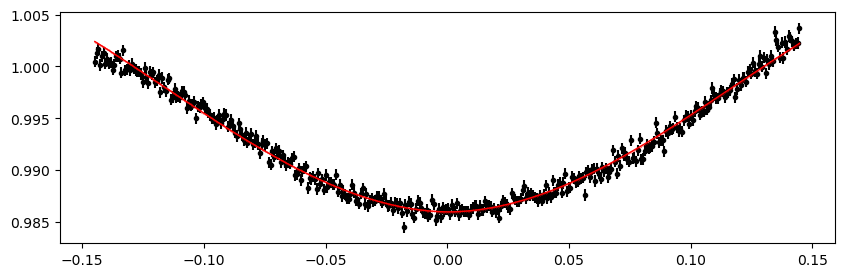

59408.765014 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.35it/s]


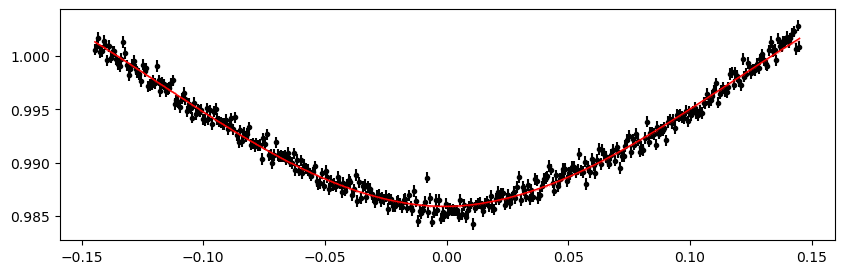

59410.670066 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.99it/s]


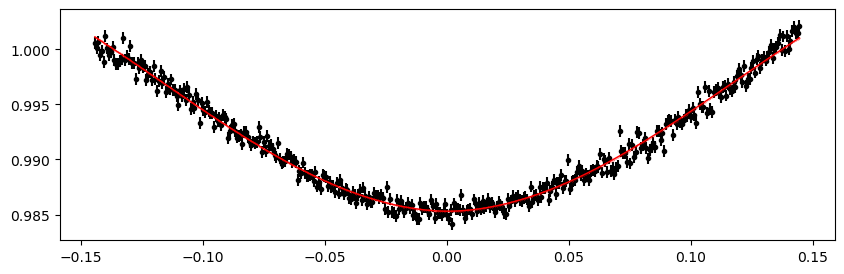

59412.57511799999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.81it/s]


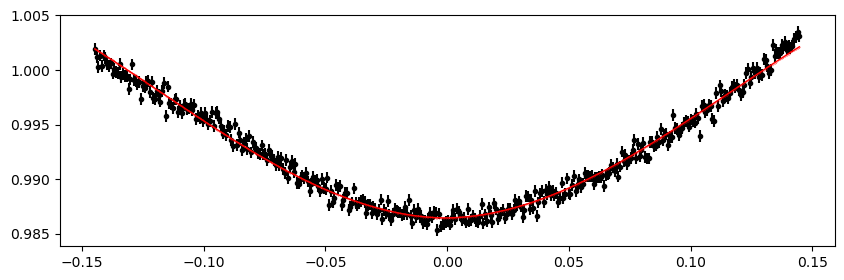

59414.480169999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 268.46it/s]


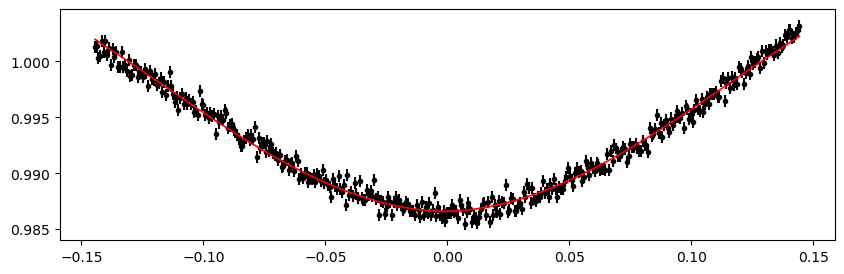

59416.385222 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.71it/s]


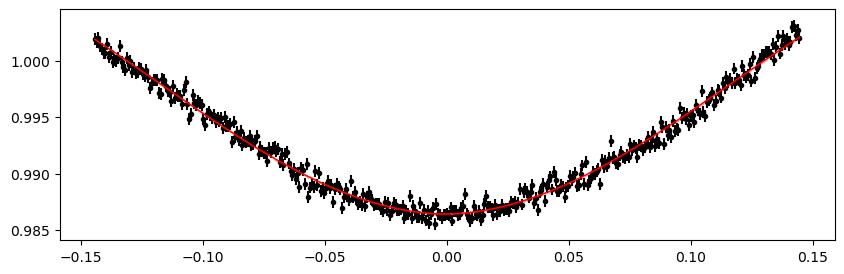

59418.290274 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.53it/s]


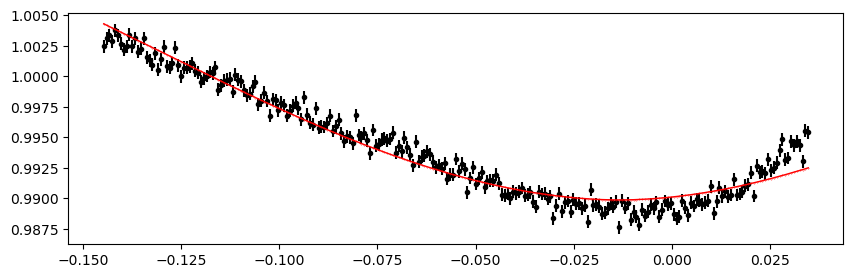

59420.195325999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.38it/s]


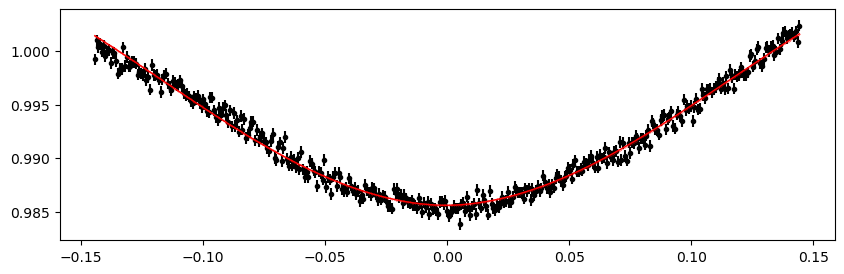

59422.100377999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 268.39it/s]


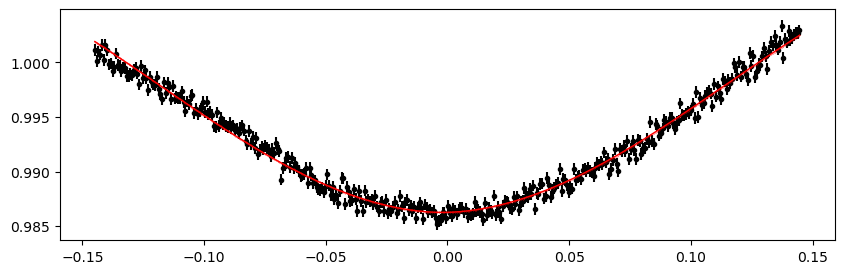

59424.00543 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.75it/s]


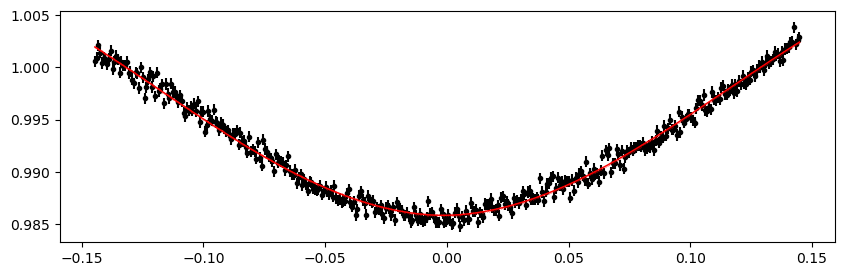

59425.910482 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.67it/s]


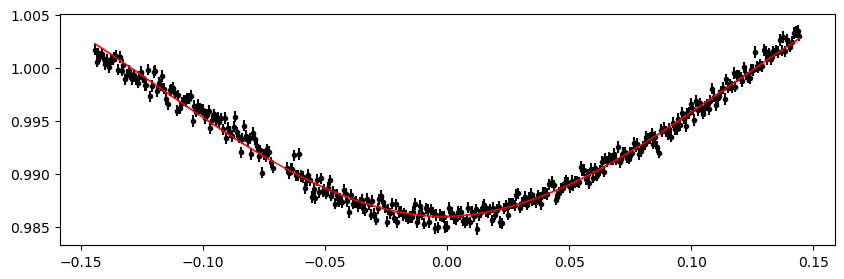

59427.815533999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.33it/s]


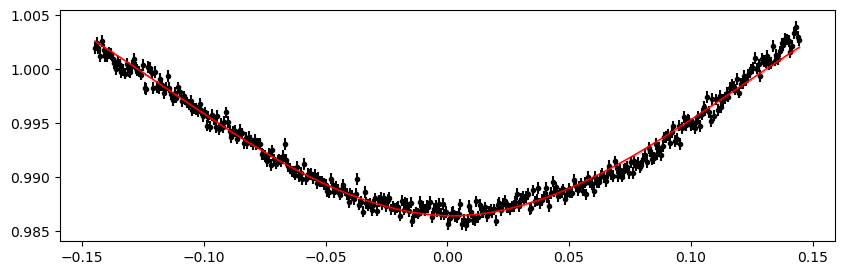

59429.720585999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 232.81it/s]


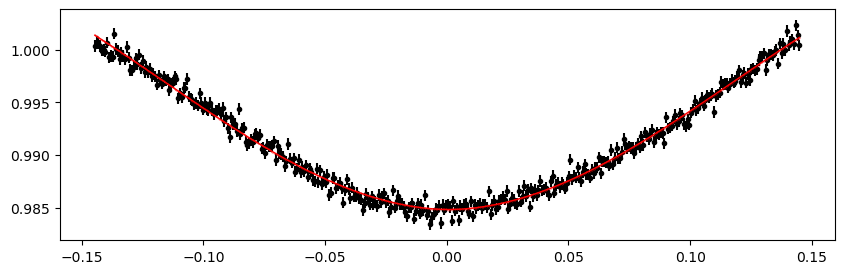

59431.625638 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.70it/s]


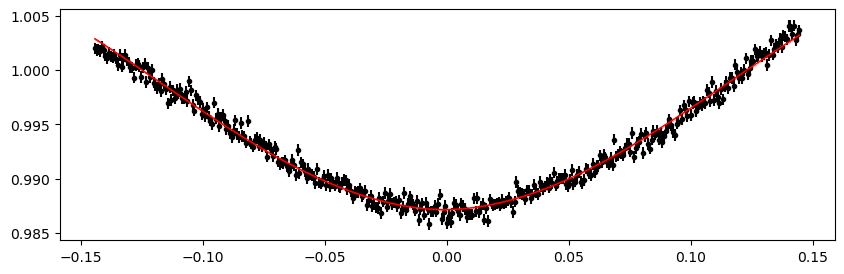

59433.53069 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.84it/s]


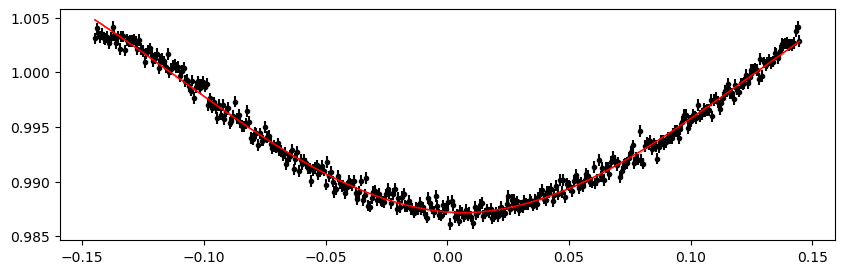

59435.435741999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.20it/s]


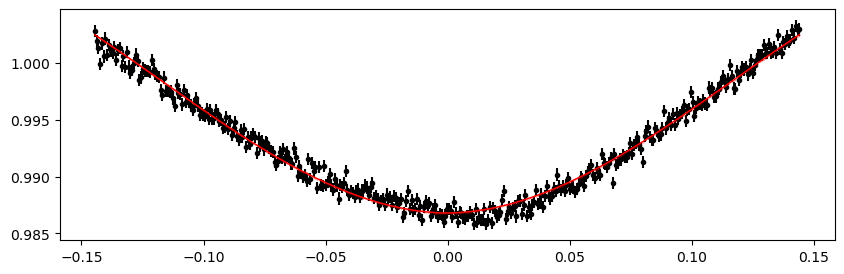

59437.340793999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.61it/s]


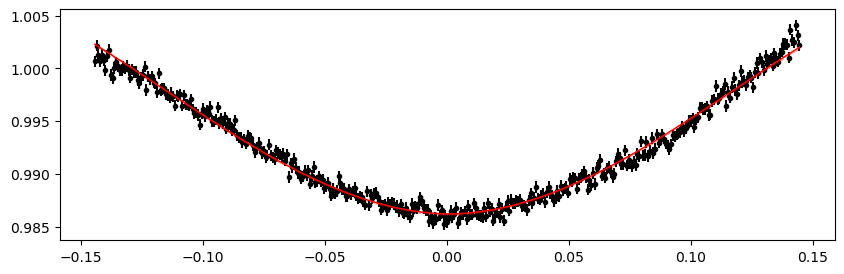

59439.245846 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.45it/s]


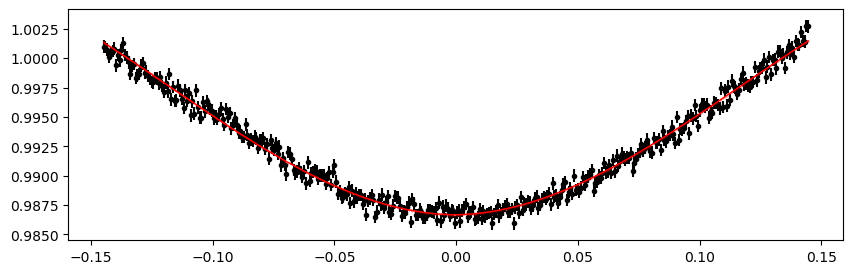

59441.15089799999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 241.65it/s]


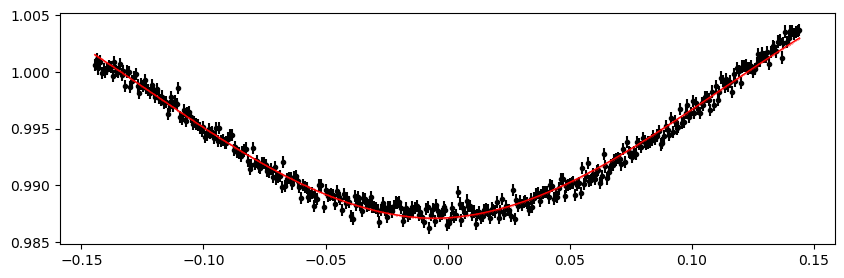

59443.055949999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.45it/s]


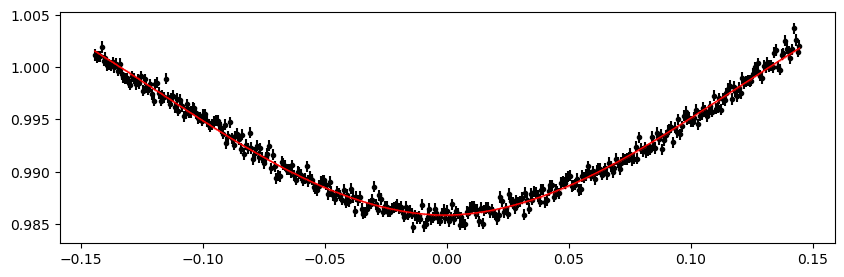

59444.961002 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.71it/s]


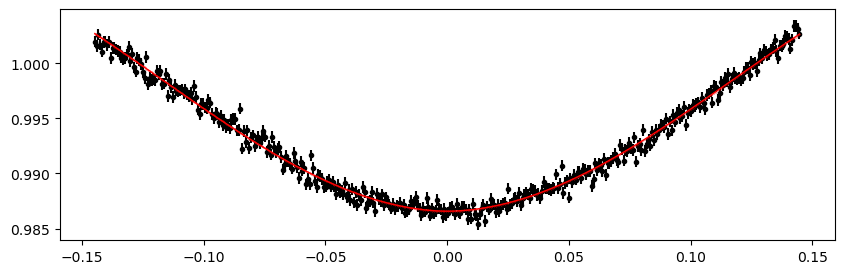

59770.724894 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.43it/s]


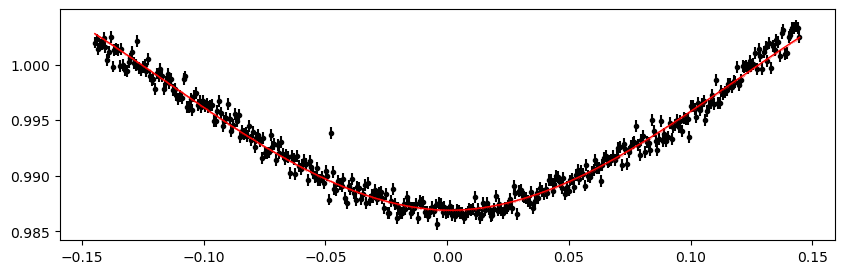

59772.629945999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 270.09it/s]


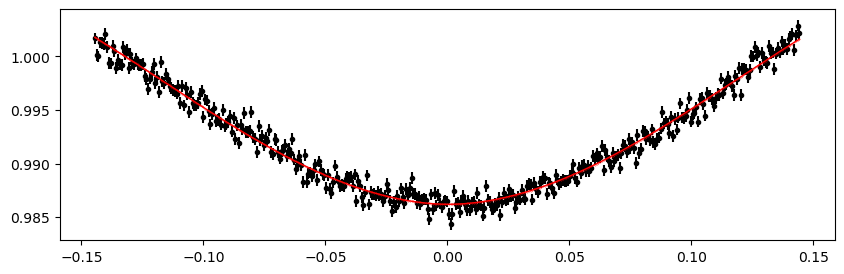

59774.534997999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.16it/s]


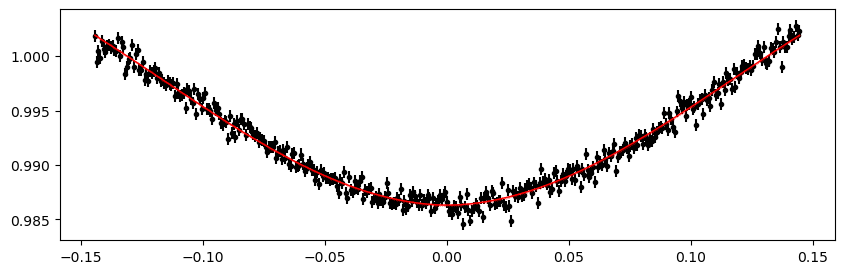

59776.44005 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.95it/s]


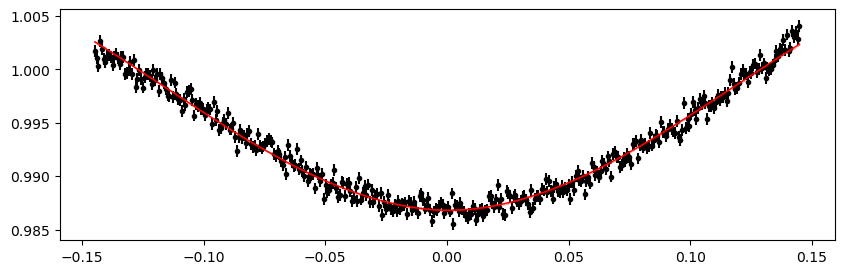

59778.345102 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.87it/s]


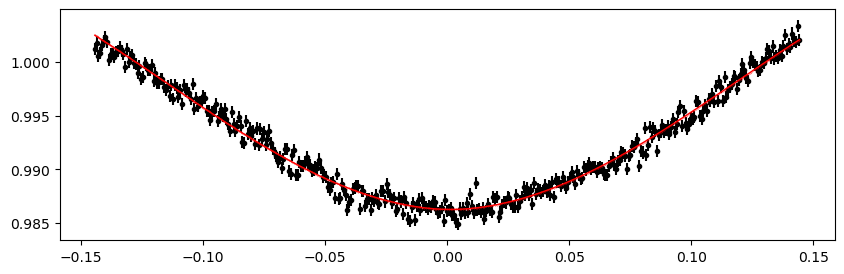

59780.250153999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.15it/s]


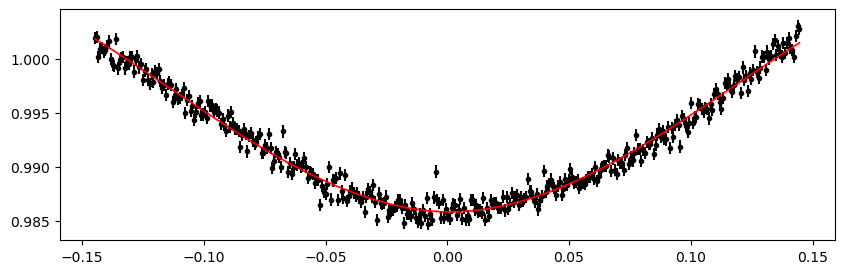

59784.060258 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.57it/s]


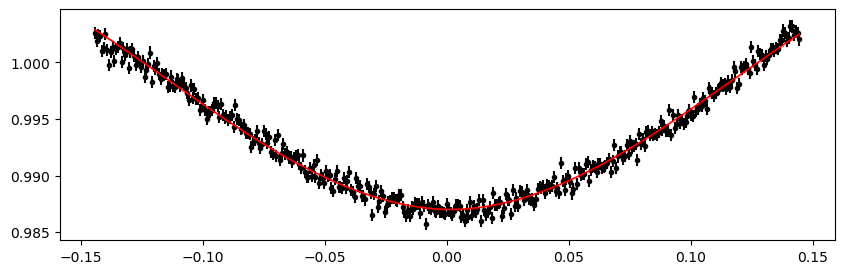

59785.96531 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.91it/s]


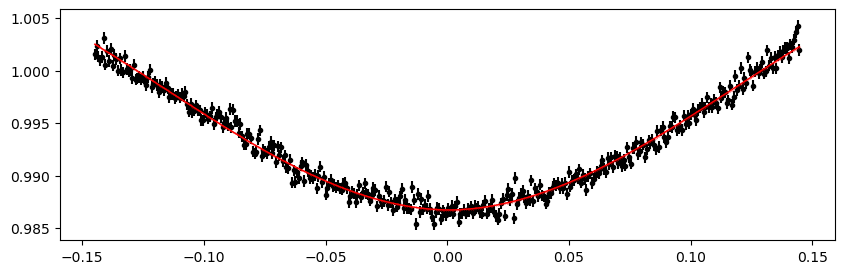

59787.870361999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.47it/s]


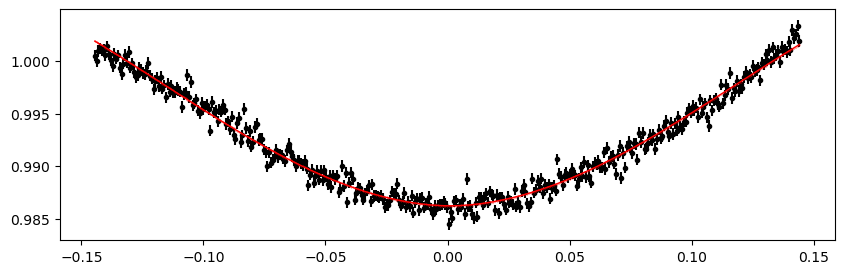

59789.775413999996 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.42it/s]


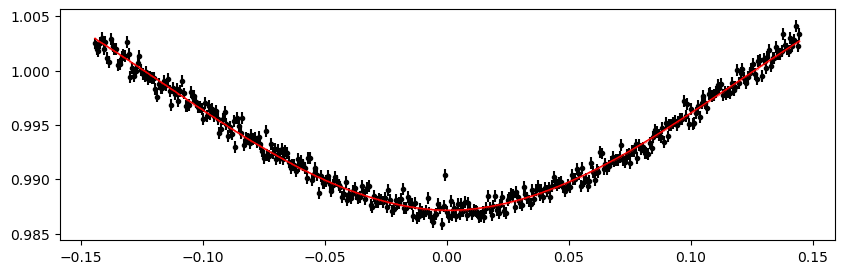

59791.680466 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.53it/s]


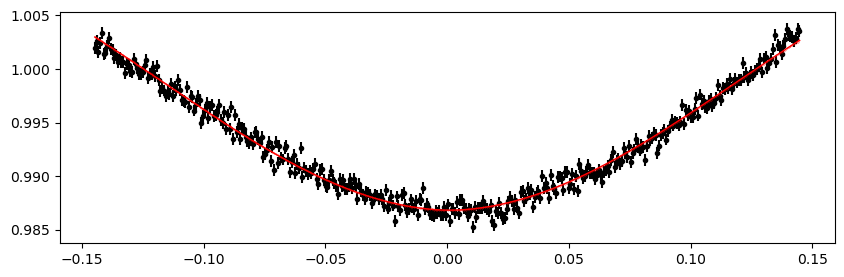

59793.58551799999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.49it/s]


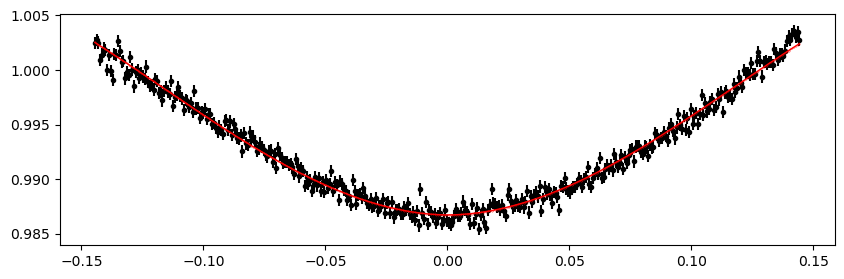

59795.490569999994 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.04it/s]


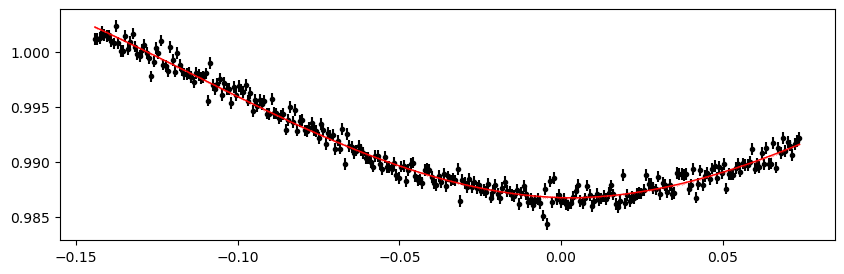

59797.395622 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.58it/s]


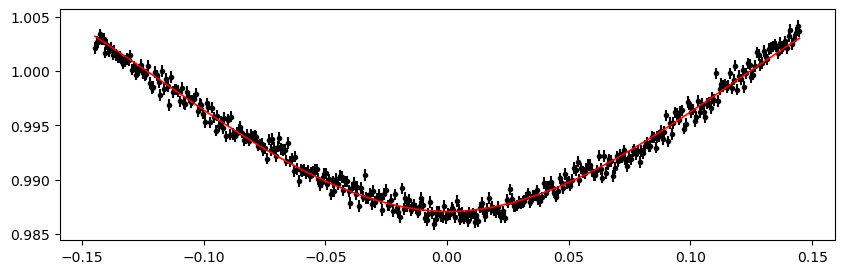

59799.300674 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.84it/s]


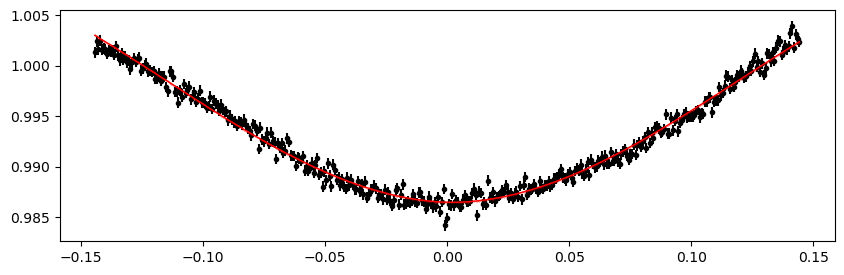

59801.20572599999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.16it/s]


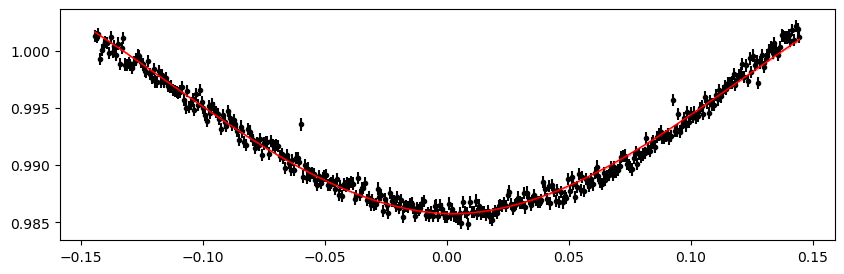

59803.110777999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 272.95it/s]


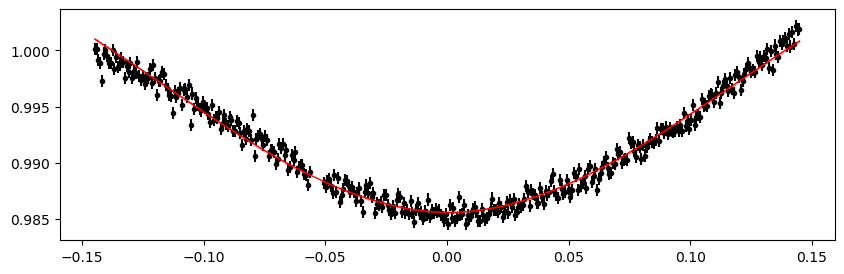

59805.01583 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.00it/s]


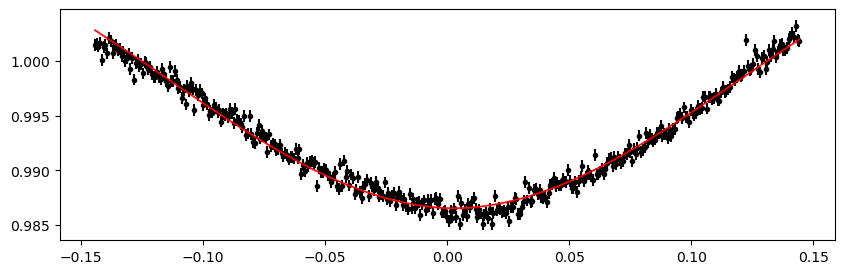

59806.920882 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.95it/s]


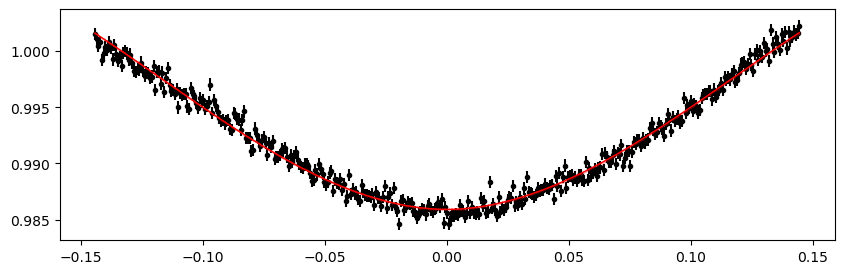

59808.82593399999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.57it/s]


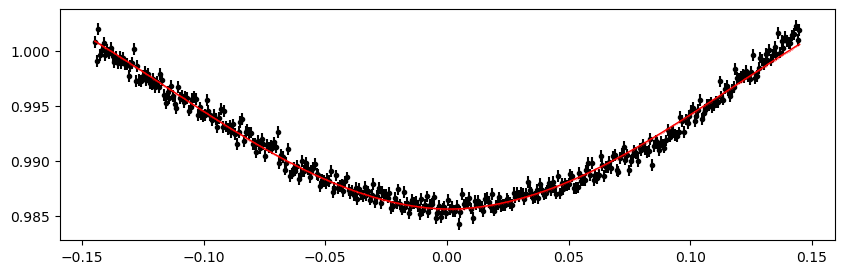

59810.730985999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.41it/s]


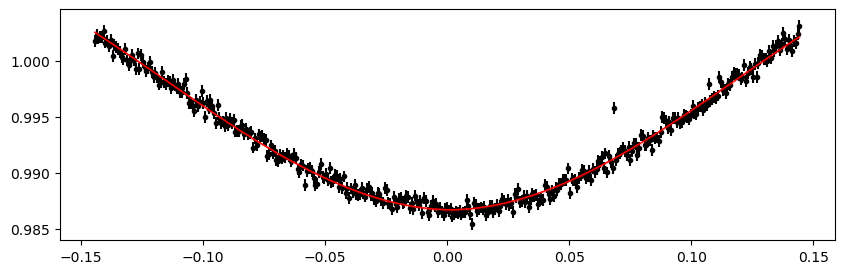

59812.636038 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 270.19it/s]


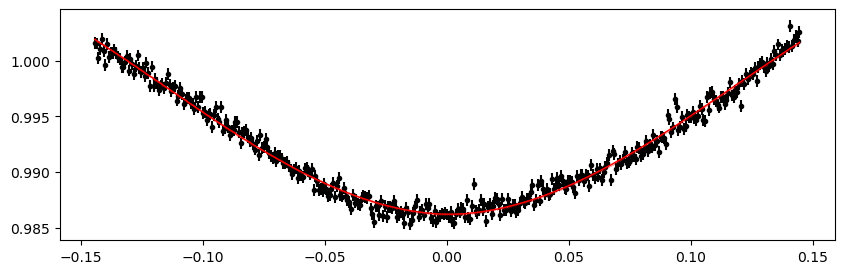

59814.54109 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.86it/s]


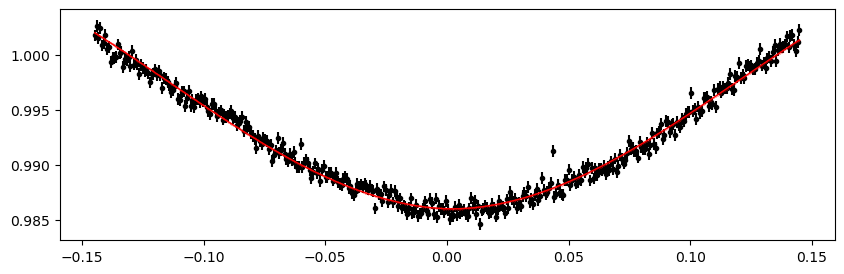

59816.44614199999 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 270.28it/s]


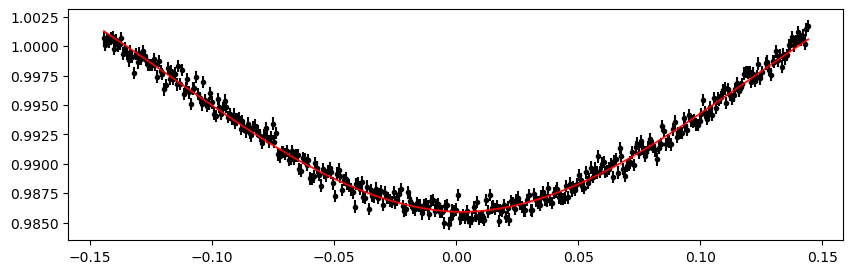

59818.351193999995 1.0117904588740738 -0.025374150600713987 0.18570110443988325


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.37it/s]


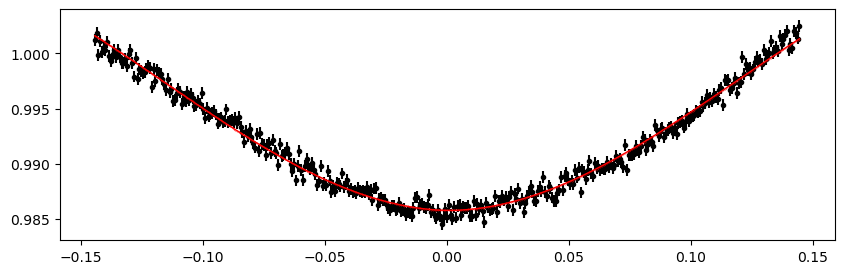

Fitting individual secondary eclipses...
Creating new manifest file
58683.947974508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.47it/s]


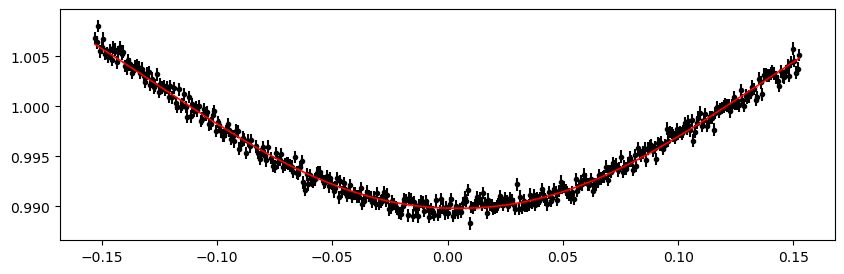

58685.853026508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 247.79it/s]


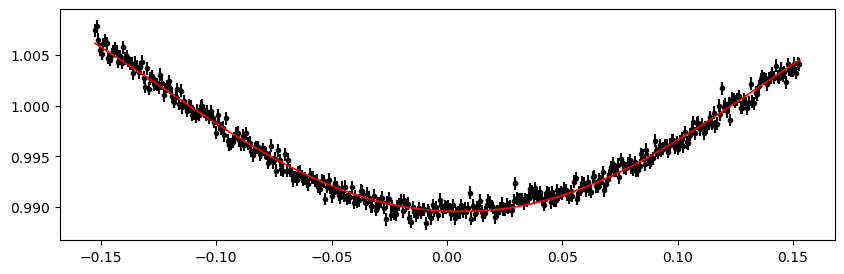

58687.758078508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.26it/s]


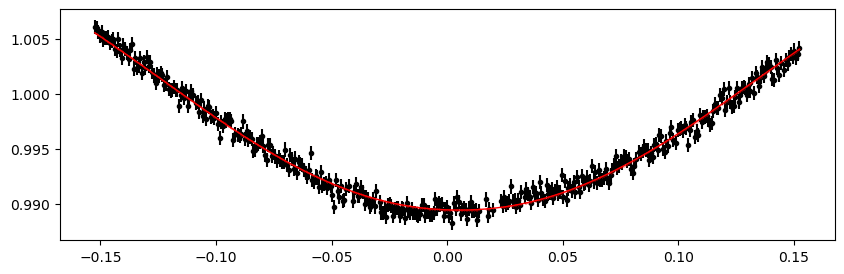

58689.663130508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.45it/s]


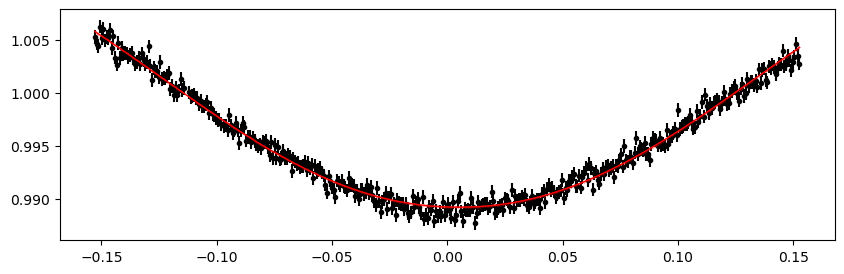

58691.568182508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.01it/s]


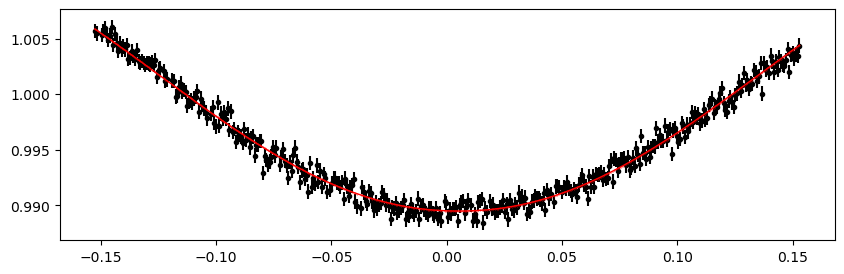

58693.473234508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.21it/s]


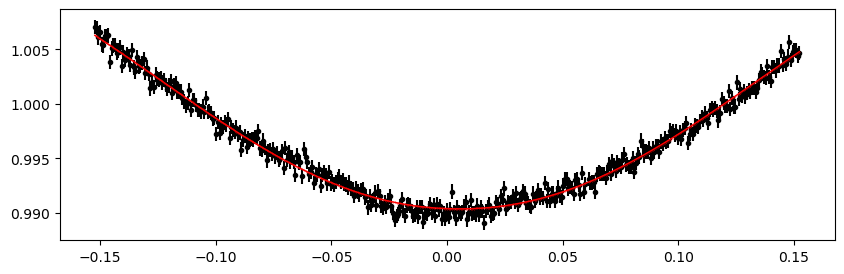

58695.378286508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.98it/s]


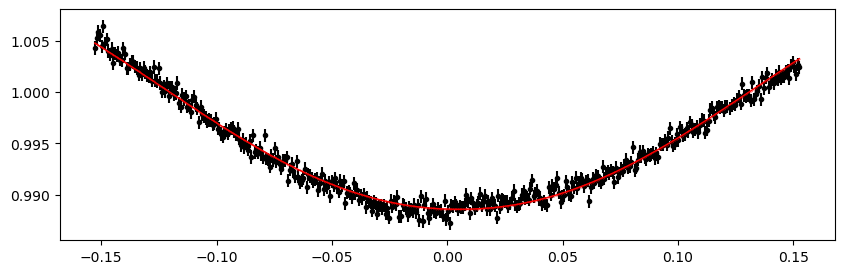

58697.283338508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.65it/s]


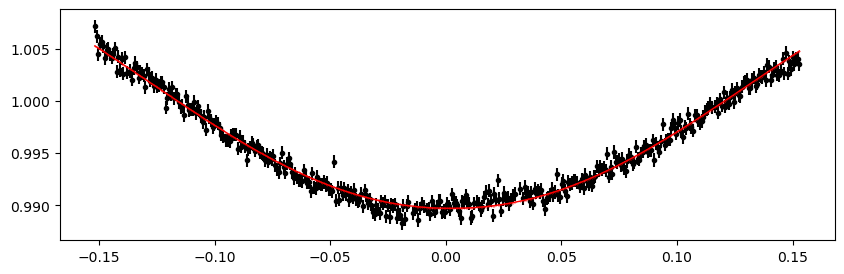

58699.188390508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 268.28it/s]


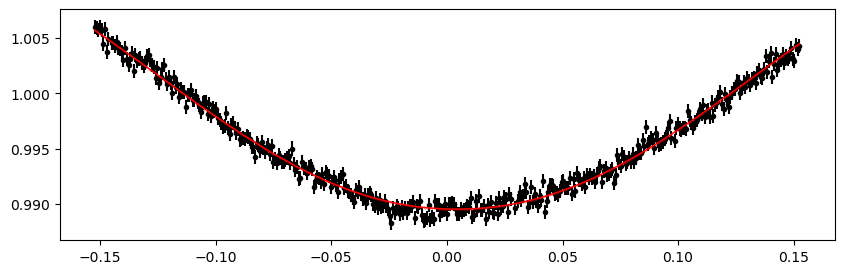

58701.093442508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 269.25it/s]


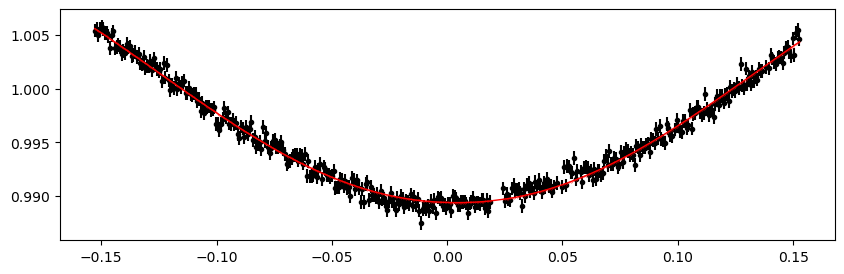

58702.998494508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.97it/s]


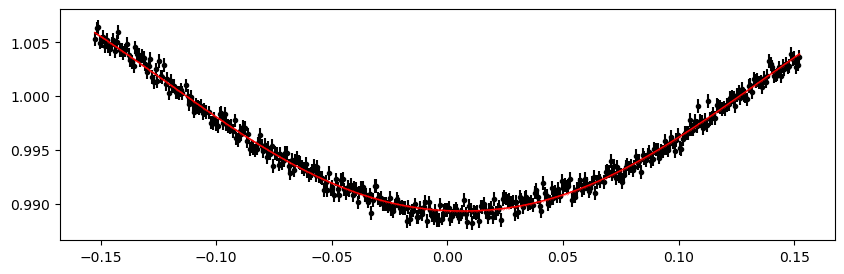

58704.903546508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.37it/s]


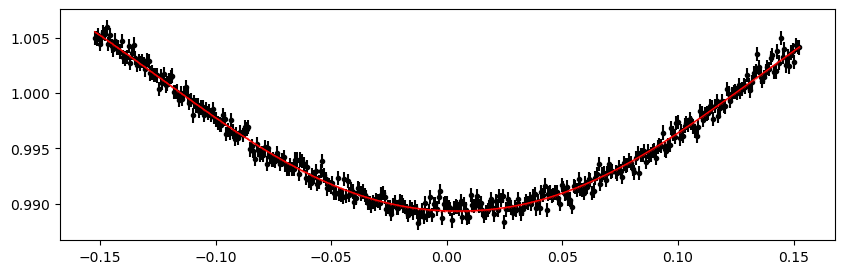

58706.808598508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.26it/s]


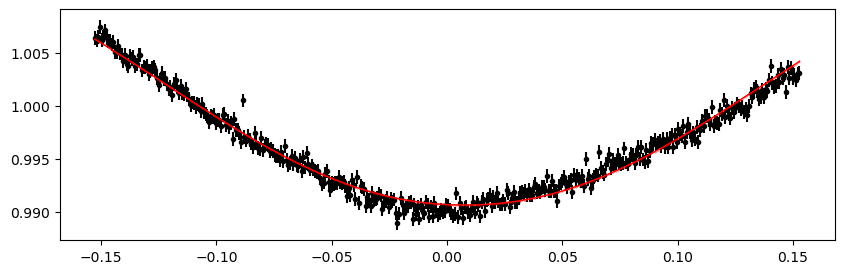

58708.713650508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.59it/s]


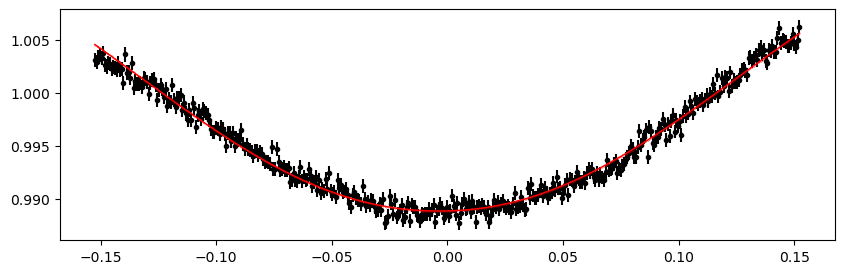

59390.722266508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.86it/s]


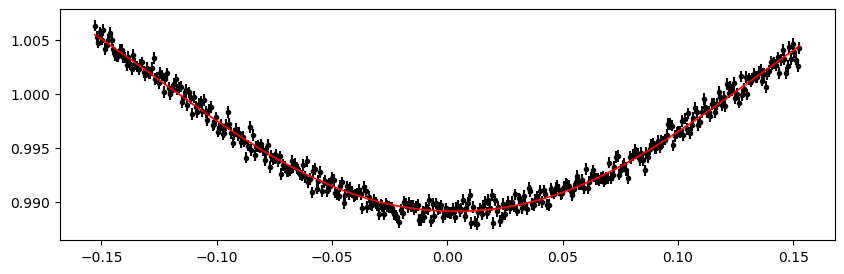

59392.627318508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.97it/s]


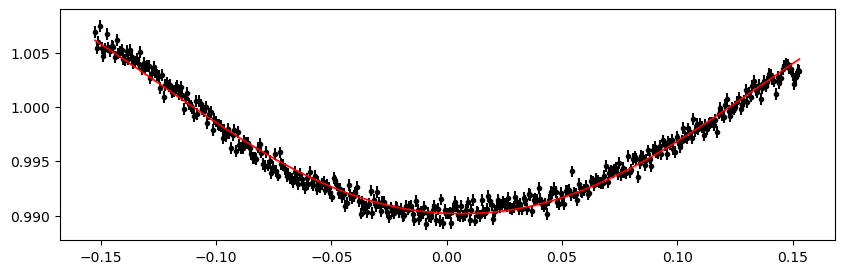

59394.532370508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.01it/s]


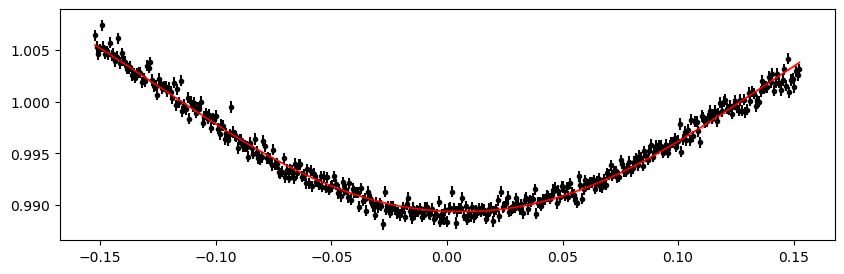

59396.437422508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.57it/s]


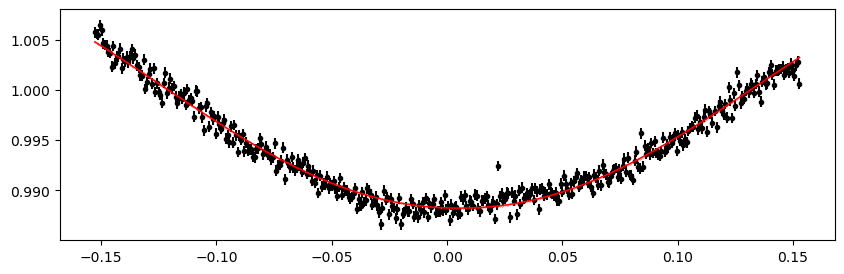

59398.342474508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.39it/s]


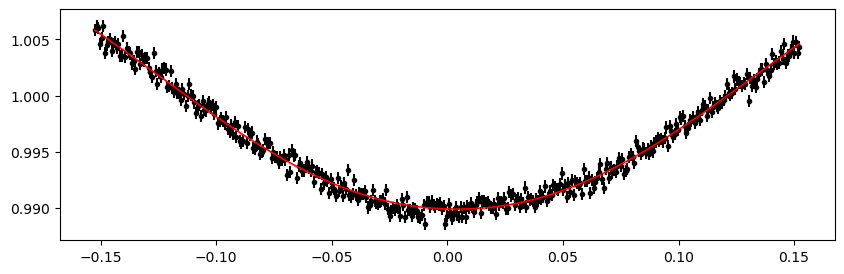

59400.247526508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.60it/s]


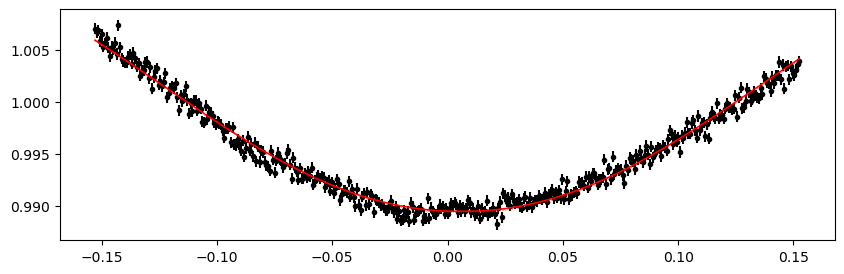

59402.152578508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.38it/s]


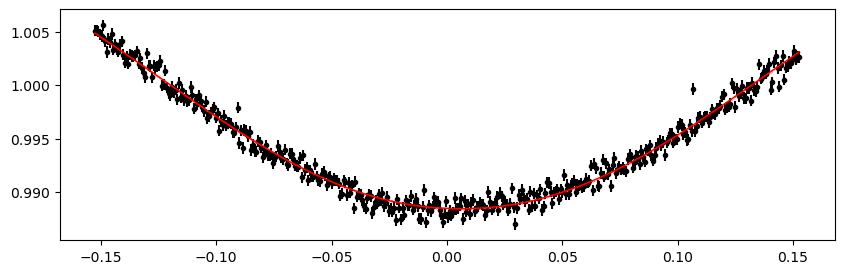

59404.057630508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.91it/s]


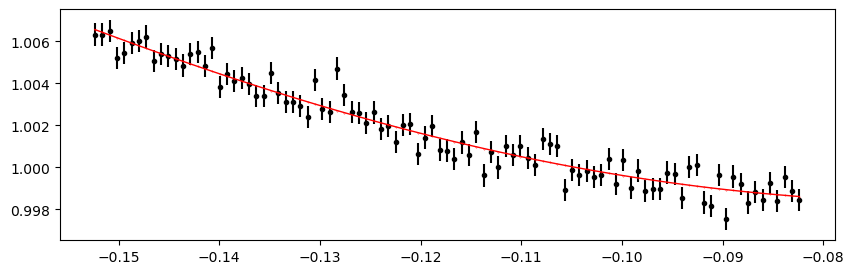

59405.962682508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.43it/s]


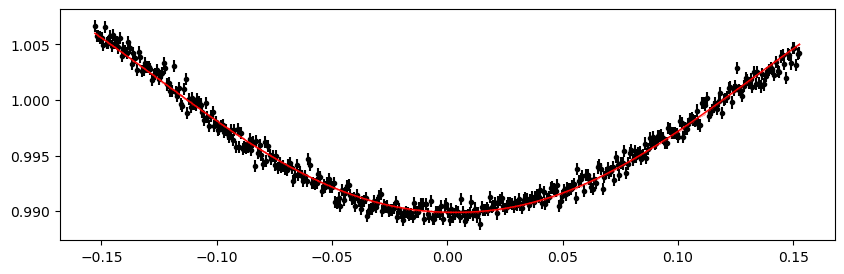

59407.867734508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.83it/s]


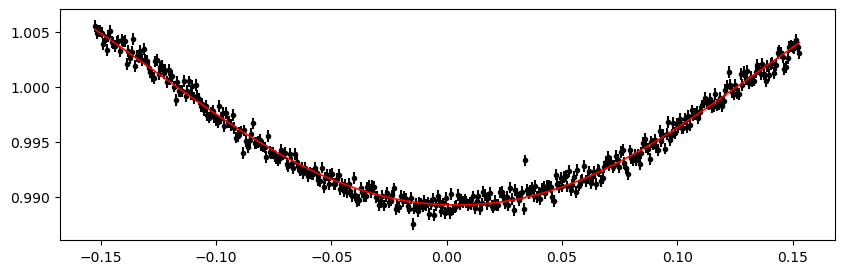

59409.772786508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.02it/s]


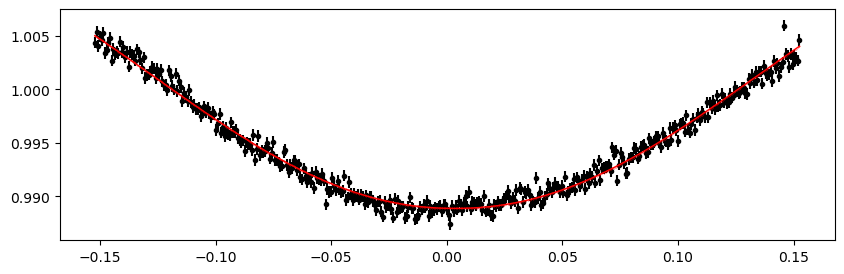

59411.677838508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.67it/s]


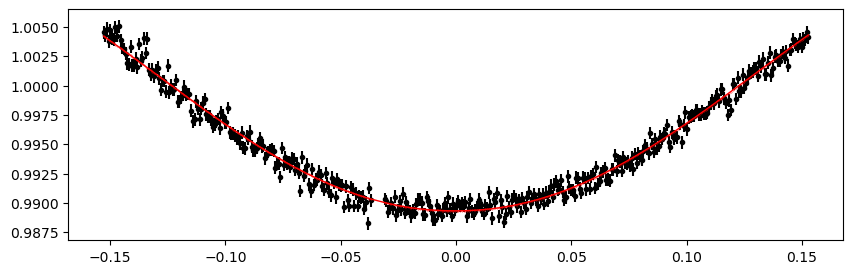

59413.582890508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 241.46it/s]


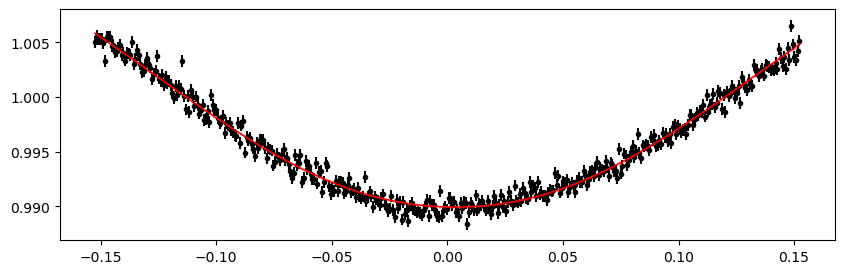

59415.487942508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.91it/s]


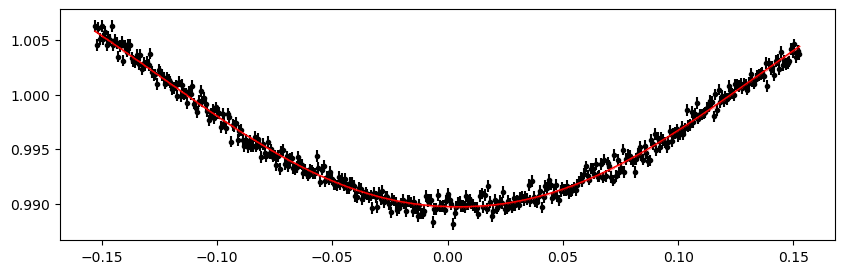

59417.392994508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.61it/s]


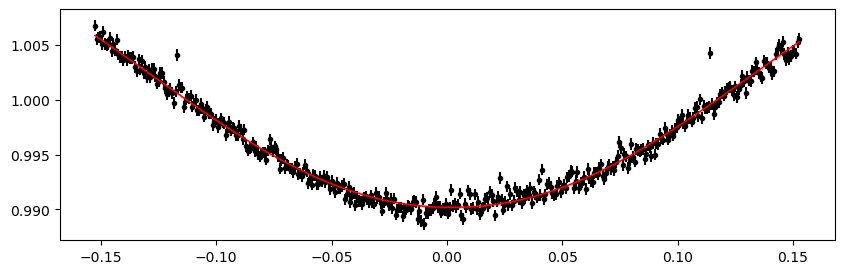

59419.298046508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.61it/s]


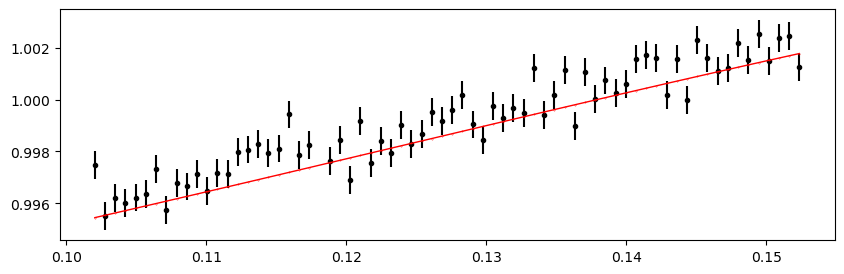

59421.203098508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.47it/s]


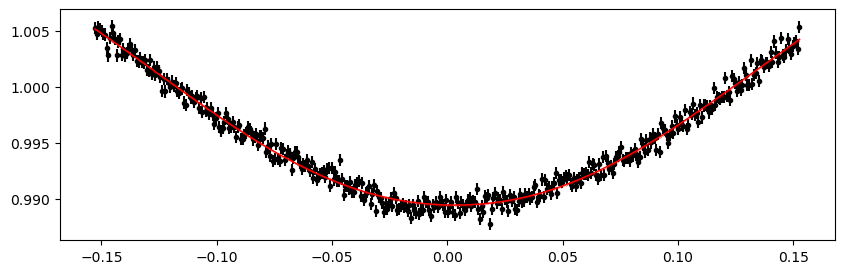

59423.108150508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.23it/s]


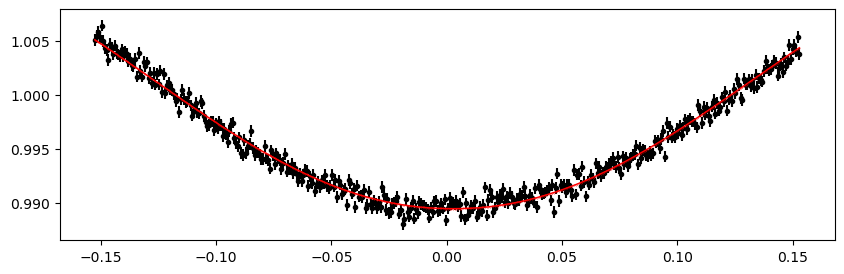

59425.013202508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 238.77it/s]


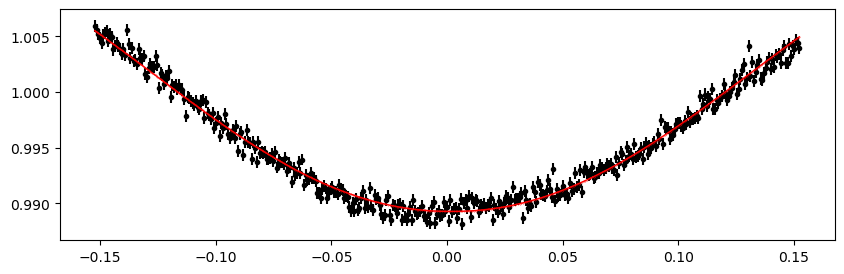

59426.918254508004 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.00it/s]


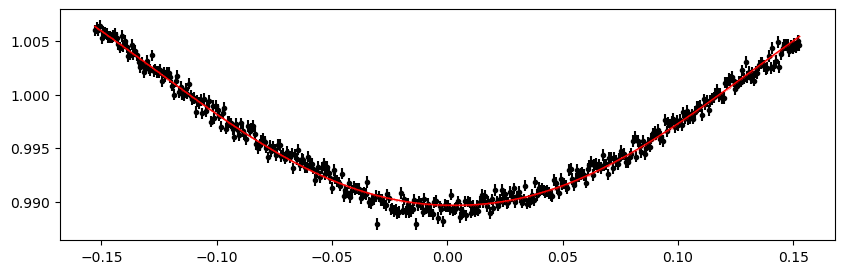

59428.823306508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.29it/s]


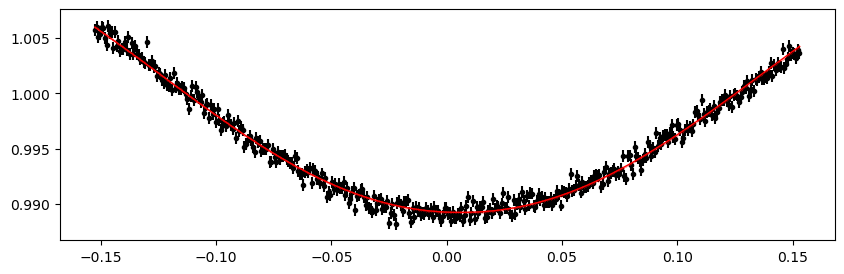

59430.728358508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.84it/s]


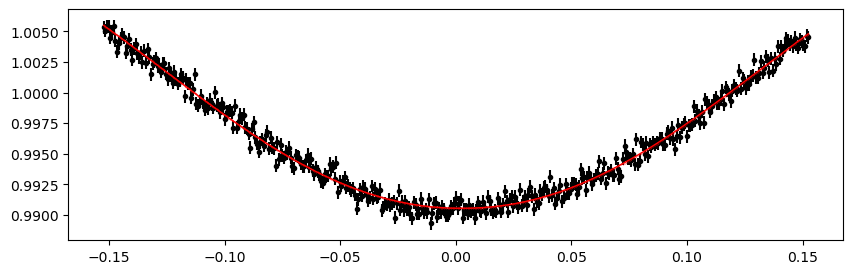

59434.538462508004 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.62it/s]


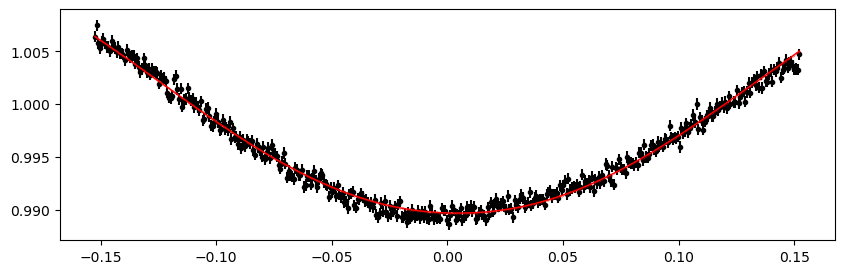

59436.443514508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.58it/s]


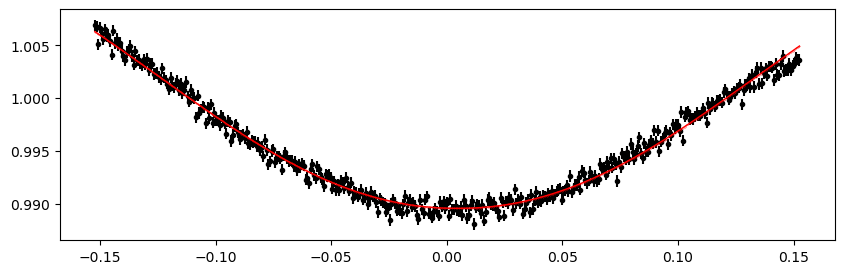

59438.348566508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.96it/s]


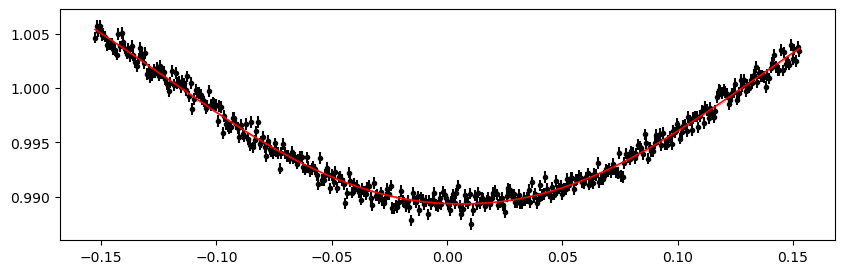

59440.253618508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.46it/s]


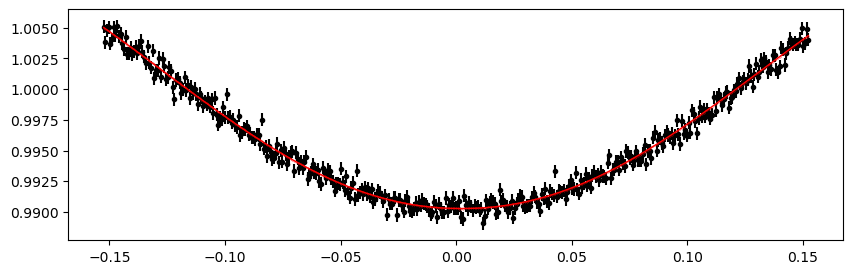

59442.158670508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.09it/s]


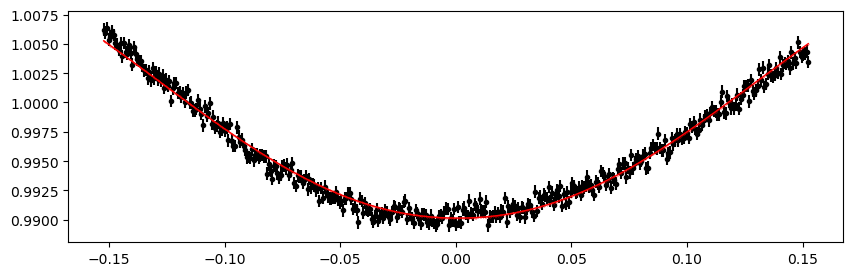

59444.063722508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.02it/s]


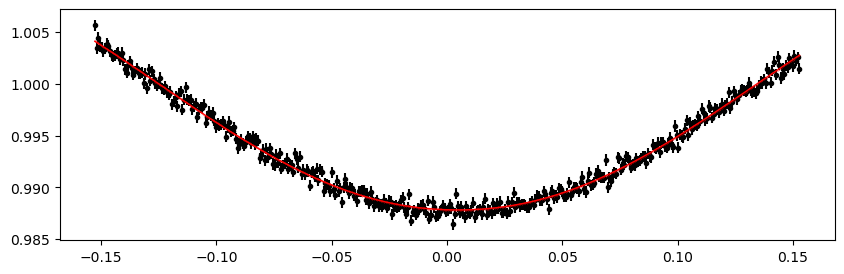

59445.968774508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.43it/s]


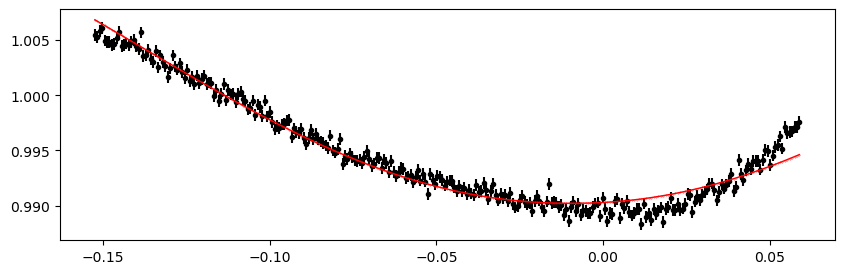

59769.827614508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.36it/s]


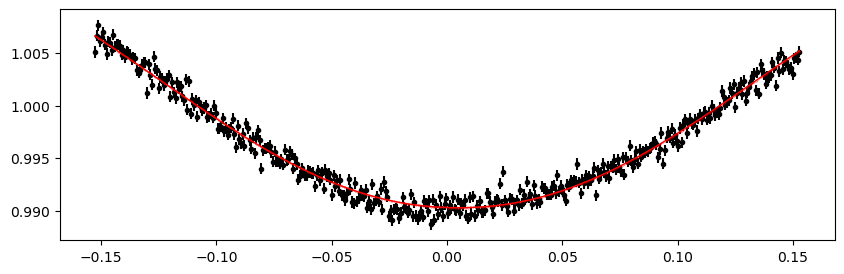

59771.732666508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.63it/s]


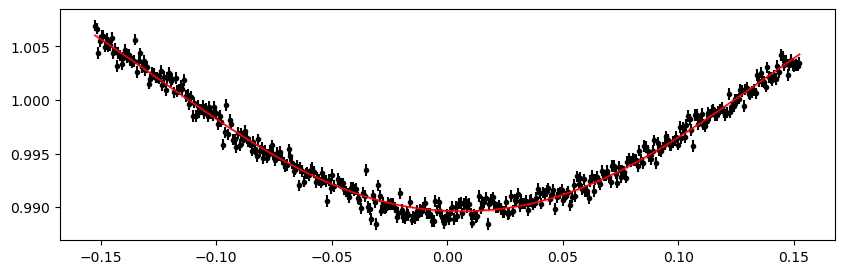

59773.637718508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.21it/s]


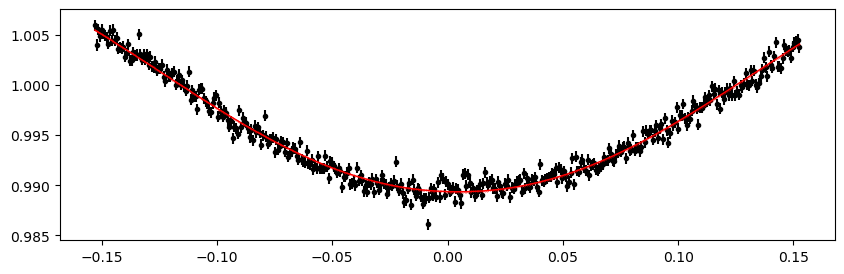

59775.542770508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 244.40it/s]


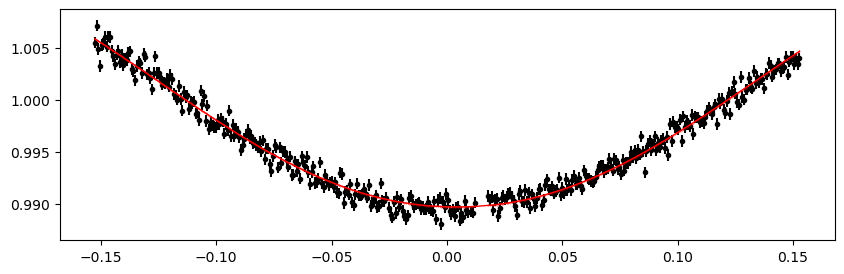

59777.447822508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.30it/s]


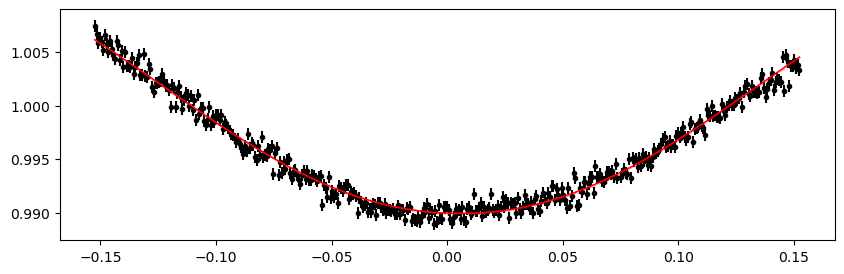

59779.352874508004 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.07it/s]


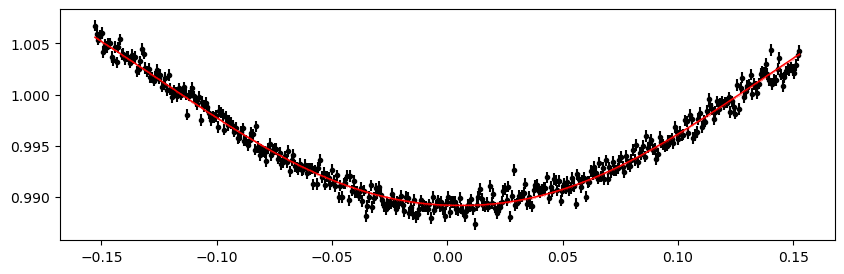

59781.257926508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.83it/s]


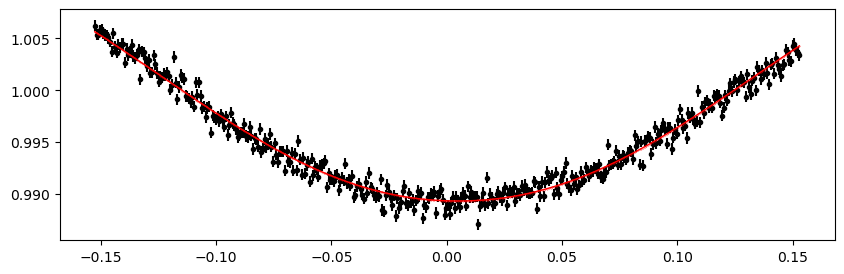

59783.162978508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 291.19it/s]


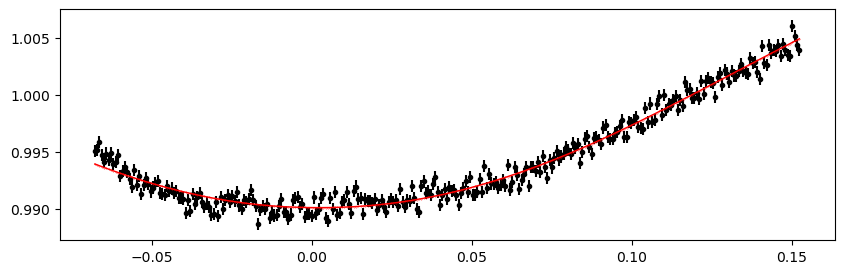

59785.068030508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.06it/s]


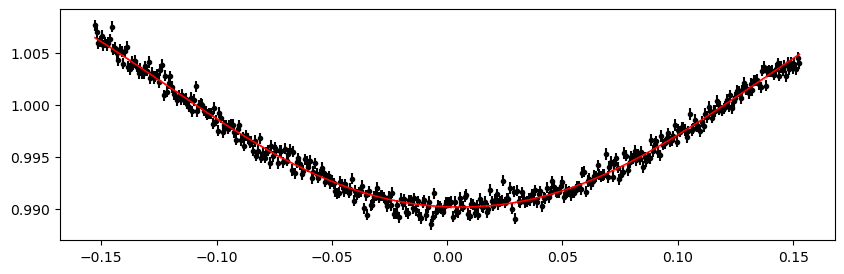

59786.973082508004 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 241.24it/s]


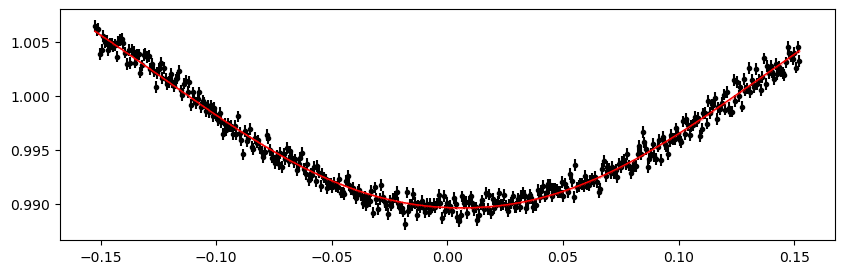

59788.878134508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.93it/s]


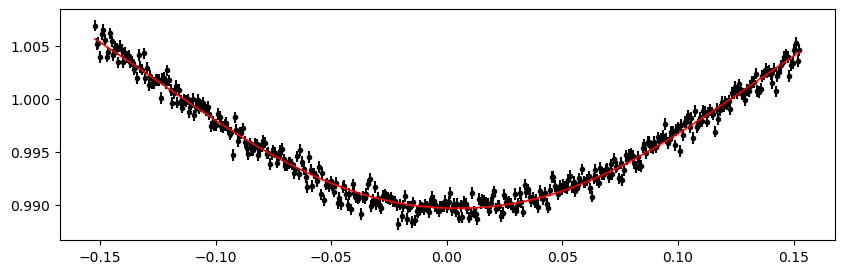

59790.783186508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.00it/s]


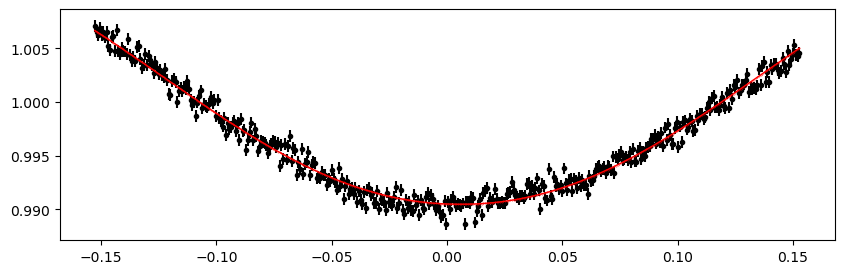

59792.688238508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.48it/s]


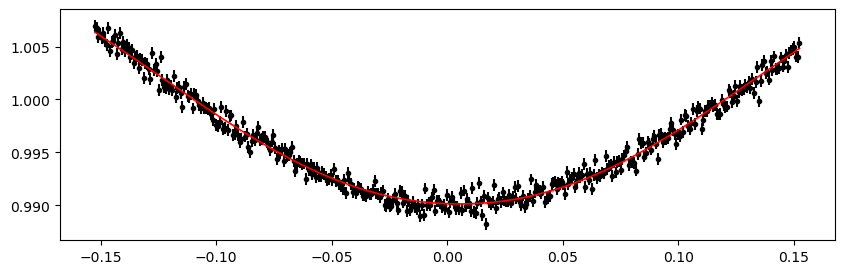

59794.593290508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.35it/s]


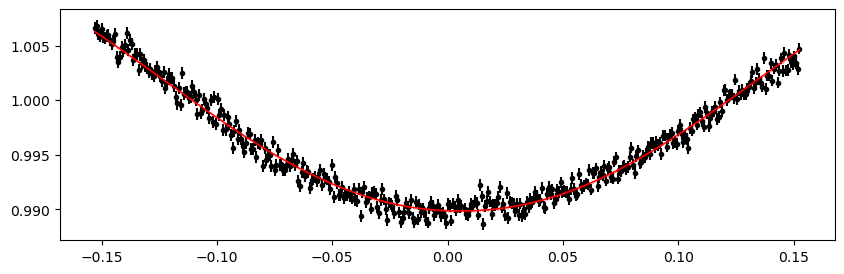

59796.498342508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.94it/s]


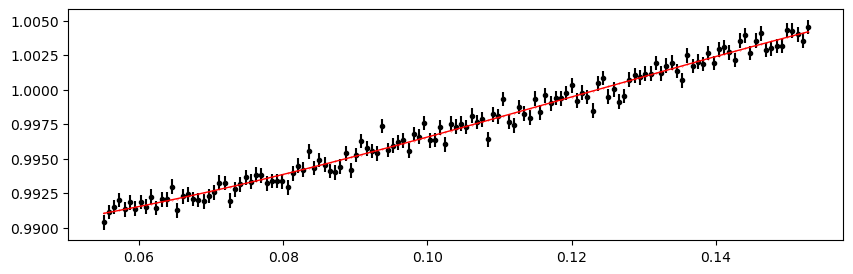

59798.403394508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.66it/s]


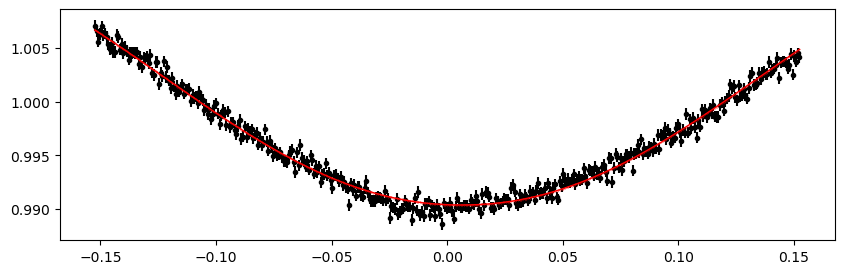

59800.308446508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 241.69it/s]


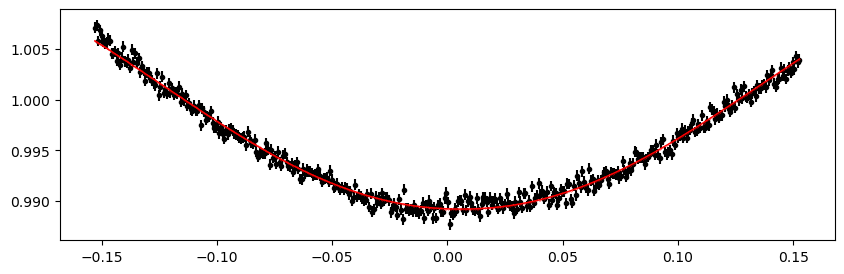

59802.213498508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.18it/s]


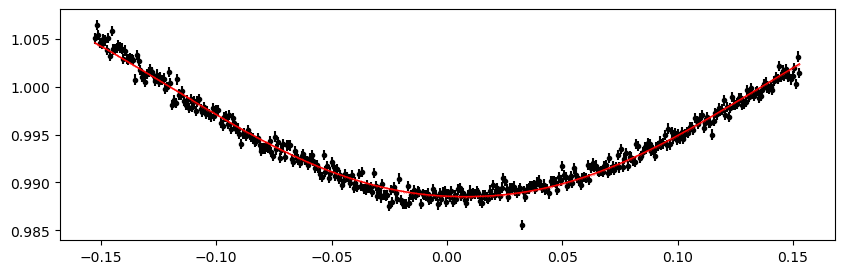

59804.118550508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.76it/s]


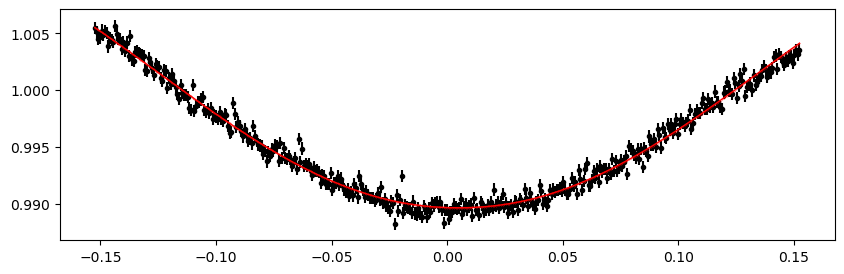

59806.023602508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.92it/s]


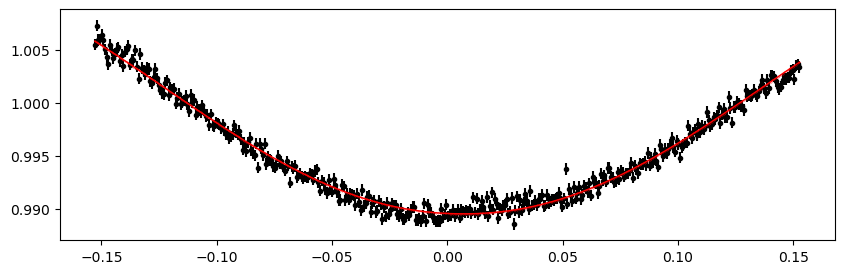

59807.928654508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.79it/s]


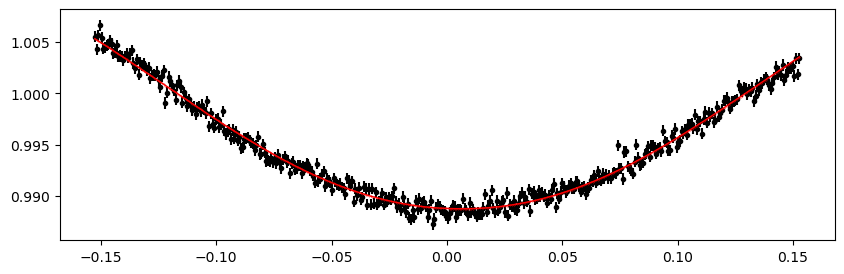

59811.738758508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.07it/s]


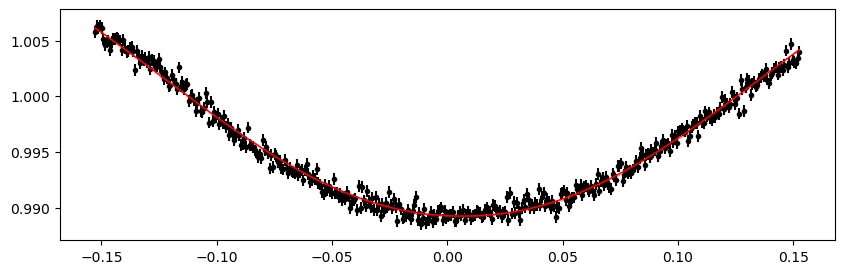

59813.643810508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.21it/s]


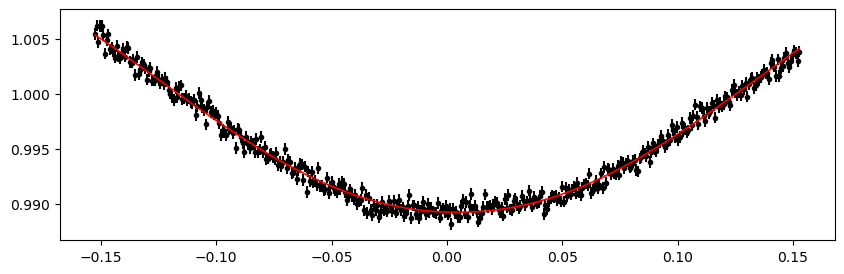

59815.548862508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.49it/s]


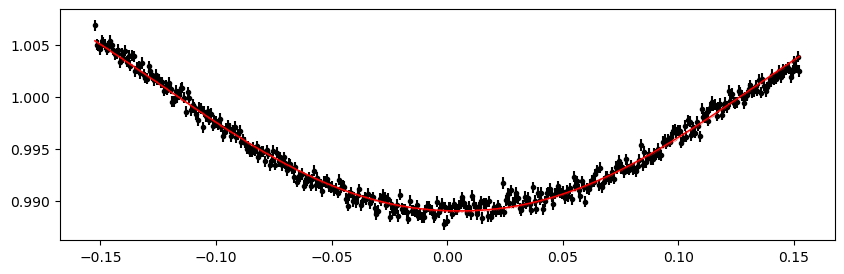

59817.453914508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.33it/s]


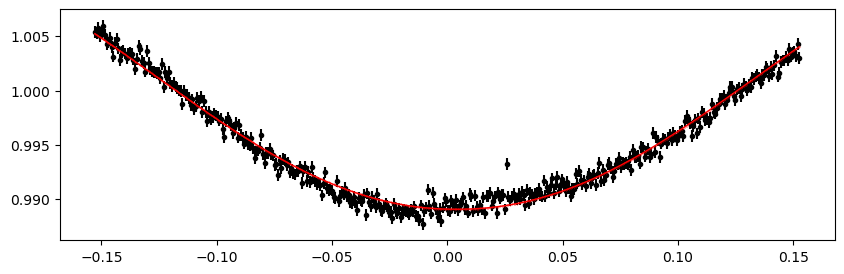

59819.358966508 1.0152185422063402 -0.025665158615984437 -0.2811307789926589


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.49it/s]


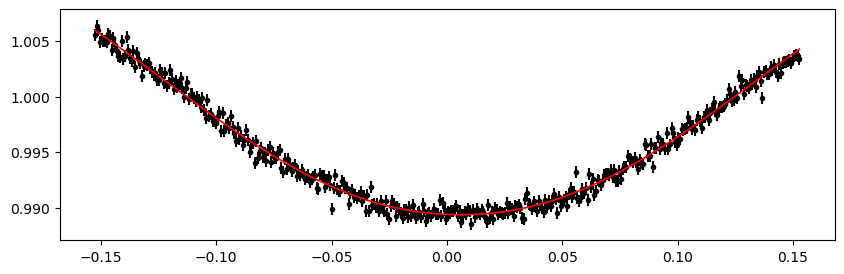

In [62]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# -----

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

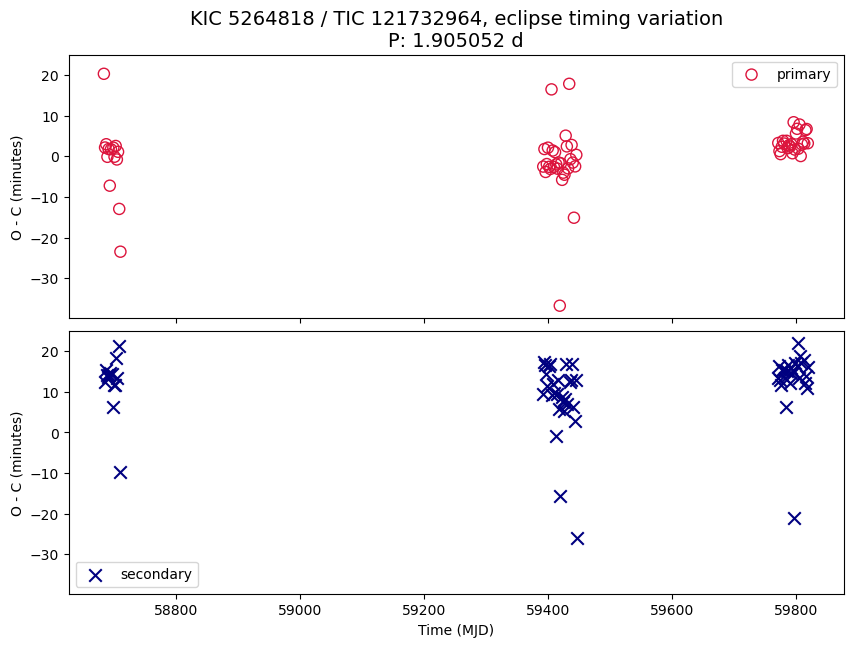

In [70]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True, sharey=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary.shift_mins > -100]
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] < 55800]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] < 55800]


    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

# ---

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 58000]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 58000]
    # in_df_secondary = in_df_secondary[in_df_secondary['shift_mins'] < 10]  # exclude a single outlier

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

# exclude some outliers
axs[0].set_ylim(20, 40)
axs[1].set_ylim(25, 50)

plt.subplots_adjust(hspace=0.05)
plt.show()


## make a periodogram 

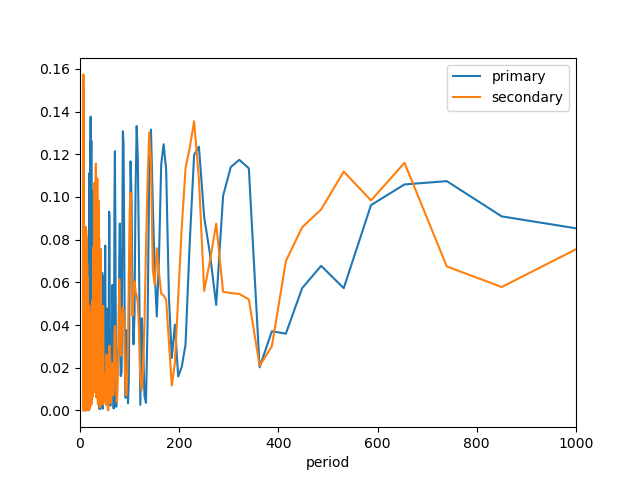

In [67]:
# TESS data roughly has a peak of ~500 days. The period found in Kepler data.
# it's understandably nosier

frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower(minimum_frequency=1 / 1000)  # ensure the max period exceeds ~500 d in the paper

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower(minimum_frequency=1 / 1000)
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


## Results Summary

In [1]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing Kepler ETV in 2013ApJ inconclusive for  TESS data, using TESS-specific initial model params. The amplitude seems to be smaller (compared with the result using the model params from Kepler data"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),  # counting TESS only
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

NameError: name 'mean_alpha1' is not defined